<a href="https://colab.research.google.com/github/Y-golabchi/Getting_Started/blob/main/EDZ_Extra_Features_ARMA2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

# **Correlation Matrix without Normalization**

In [2]:
# Reading the excel file

# from google.colab import drive
# drive.mount('/content/drive')

EDZ = pd.read_excel('/content/EDZ_input_data_Final.xlsx')

# # Turn excel file to csv
# EDZ_excel.to_csv('EDZ.csv', index=False)
# # Reading the CSV file
# EDZ=pd.read_csv('/content/EDZ.csv', header = 0)

In [3]:
EDZ.columns

Index(['Run No.', 'Run No..1', 'File Name', 'Young's Modulus', 'UCS', 'CI',
       'T', 'mb peak', 's peak', 'Sig1', 'Sig3', 'SigMax', 'SigZ', 'HDZ',
       'EDZi', 'EDZo', 'HDZ/a', 'EDZi/a', 'EDZo/a'],
      dtype='object')

In [4]:
#Droping the first row (units)
EDZ.drop(0, axis=0, inplace=True)


# Convert specific columns to float64
columns_to_convert = ['Run No.', 'Run No..1', 'Young\'s Modulus', 'UCS', 'CI',
       'T', 'mb peak', 's peak', 'Sig1', 'Sig3', 'SigMax', 'SigZ', 'HDZ',
       'EDZi', 'EDZo', 'HDZ/a', 'EDZi/a', 'EDZo/a']
EDZ[columns_to_convert] = EDZ[columns_to_convert].astype(float)

print(EDZ.dtypes)

Run No.            float64
Run No..1          float64
File Name           object
Young's Modulus    float64
UCS                float64
CI                 float64
T                  float64
mb peak            float64
s peak             float64
Sig1               float64
Sig3               float64
SigMax             float64
SigZ               float64
HDZ                float64
EDZi               float64
EDZo               float64
HDZ/a              float64
EDZi/a             float64
EDZo/a             float64
dtype: object


In [5]:
EDZ.columns


Index(['Run No.', 'Run No..1', 'File Name', 'Young's Modulus', 'UCS', 'CI',
       'T', 'mb peak', 's peak', 'Sig1', 'Sig3', 'SigMax', 'SigZ', 'HDZ',
       'EDZi', 'EDZo', 'HDZ/a', 'EDZi/a', 'EDZo/a'],
      dtype='object')

In [6]:
EDZ

,Run No.,Run No..1,File Name,Young's Modulus,UCS,CI,T,mb peak,s peak,Sig1,Sig3,SigMax,SigZ,HDZ,EDZi,EDZo,HDZ/a,EDZi/a,EDZo/a
1,438.0,438.0,Shale_KHh1p5_plastic_UCS52,15000.0,51.82,17.32,2.16500,0.298704,0.012480,13.5,9.0,31.5,5.4,0.50,1.20,1.90,1.153846,1.369231,1.584615
2,439.0,439.0,Shale_KHh1p5_plastic_UCS19,15000.0,18.77,7.56,0.94500,0.522712,0.026317,13.5,9.0,31.5,5.4,0.80,2.30,4.80,1.246154,1.707692,2.476923
3,441.0,441.0,Shale_KHh1p5_plastic_UCS58,15000.0,57.84,24.84,3.10500,0.633665,0.034017,13.5,9.0,31.5,5.4,0.30,0.50,0.80,1.092308,1.153846,1.246154
4,442.0,442.0,Shale_KHh1p5_plastic_UCS51,15000.0,50.66,18.68,2.33500,0.401074,0.018486,13.5,9.0,31.5,5.4,0.50,1.20,1.75,1.153846,1.369231,1.538462
5,443.0,443.0,Shale_KHh1p5_plastic_UCS44,15000.0,44.09,19.60,2.45000,0.702810,0.039054,13.5,9.0,31.5,5.4,0.60,1.20,1.60,1.184615,1.369231,1.492308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,NaN,NaN,Limestone_KHh1p5_plastic_UCS140,40000.0,146.87,41.36,5.17000,0.178662,0.006289,94.0,87.0,195.0,67.0,1.35,2.43,4.80,1.415385,1.747692,2.476923
422,NaN,NaN,Limestone_KHh1p5_plastic_UCS141,40000.0,121.64,44.05,5.50625,0.379926,0.017198,54.0,23.0,139.0,20.0,0.75,1.40,2.47,1.230769,1.430769,1.760000
423,NaN,NaN,Limestone_KHh1p5_plastic_UCS142,40000.0,121.64,44.05,5.50625,0.379926,0.017198,63.0,31.0,158.0,24.0,0.75,1.70,2.98,1.230769,1.523077,1.916923
424,NaN,NaN,Limestone_KHh1p5_plastic_UCS143,40000.0,121.64,44.05,5.50625,0.379926,0.017198,76.0,65.0,163.0,48.0,1.34,2.63,4.30,1.412308,1.809231,2.323077


In [7]:
# showing different columns
EDZ.columns


Index(['Run No.', 'Run No..1', 'File Name', 'Young's Modulus', 'UCS', 'CI',
       'T', 'mb peak', 's peak', 'Sig1', 'Sig3', 'SigMax', 'SigZ', 'HDZ',
       'EDZi', 'EDZo', 'HDZ/a', 'EDZi/a', 'EDZo/a'],
      dtype='object')

In [8]:
#Droping the first row (units)

# EDZ.drop(0, axis=0, inplace=True)
# EDZ.drop(['Young\'s Modulus'], axis=1, inplace=True)

In [9]:
EDZ['EDZo/a']

1      1.584615
2      2.476923
3      1.246154
4      1.538462
5      1.492308
         ...   
421    2.476923
422    1.760000
423    1.916923
424    2.323077
425    2.400000
Name: EDZo/a, Length: 425, dtype: float64

In [10]:
EDZ.shape


(425, 19)

In [11]:
EDZ.isnull().sum()

Run No.            105
Run No..1          105
File Name            0
Young's Modulus      0
UCS                  0
CI                   0
T                    0
mb peak              0
s peak               0
Sig1                 0
Sig3                 0
SigMax               0
SigZ                 0
HDZ                  0
EDZi                 0
EDZo                 0
HDZ/a                0
EDZi/a               0
EDZo/a               0
dtype: int64

In [12]:
EDZ.describe()

,Run No.,Run No..1,Young's Modulus,UCS,CI,T,mb peak,s peak,Sig1,Sig3,SigMax,SigZ,HDZ,EDZi,EDZo,HDZ/a,EDZi/a,EDZo/a
count,320.000000,320.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,327.256250,327.253125,45870.588235,138.326541,63.062353,7.858019,0.666127,0.037827,57.405064,30.659820,141.555372,21.974506,0.674200,1.391694,2.509654,1.207446,1.428938,1.772135
std,231.636153,231.637949,21728.268386,75.748629,42.454387,5.279301,0.326229,0.026127,44.779933,21.043679,114.687035,16.690483,0.461745,0.622003,1.647592,0.142075,0.191976,0.506706
min,37.000000,37.000000,15000.000000,18.770000,7.560000,0.945000,0.147884,0.005474,13.500000,6.750000,31.500000,5.400000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,119.750000,119.750000,40000.000000,81.990000,31.340000,3.917500,0.462460,0.020010,33.660000,16.900000,78.540000,13.431429,0.300000,0.900000,1.350000,1.092308,1.276923,1.415385
50%,210.500000,210.500000,40000.000000,113.960000,43.490000,5.506250,0.550327,0.027873,33.750000,22.500000,84.350000,13.500000,0.600000,1.300000,2.000000,1.184615,1.400000,1.615385
75%,563.250000,563.250000,75000.000000,224.100000,110.190000,13.533750,0.951023,0.058452,67.500000,45.000000,168.750000,27.000000,0.950000,1.750000,3.200000,1.292308,1.550769,1.984615
max,707.000000,707.000000,75000.000000,288.600000,171.740000,21.467500,3.211713,0.296162,235.000000,112.370000,620.000000,85.000000,2.260000,2.990000,11.210000,1.695385,1.920000,4.449231


In [13]:
print(EDZ.dtypes)

Run No.            float64
Run No..1          float64
File Name           object
Young's Modulus    float64
UCS                float64
CI                 float64
T                  float64
mb peak            float64
s peak             float64
Sig1               float64
Sig3               float64
SigMax             float64
SigZ               float64
HDZ                float64
EDZi               float64
EDZo               float64
HDZ/a              float64
EDZi/a             float64
EDZo/a             float64
dtype: object


In [14]:
# EDZo= EDZ.drop(['EDZi/a', 'HDZ/a'], axis=1, inplace=False)


In [15]:
print(EDZ.nunique())

Run No.            315
Run No..1          315
File Name          262
Young's Modulus      3
UCS                111
CI                 108
T                  118
mb peak            143
s peak             116
Sig1               123
Sig3               115
SigMax             133
SigZ               112
HDZ                 49
EDZi               100
EDZo               123
HDZ/a               42
EDZi/a              94
EDZo/a             121
dtype: int64


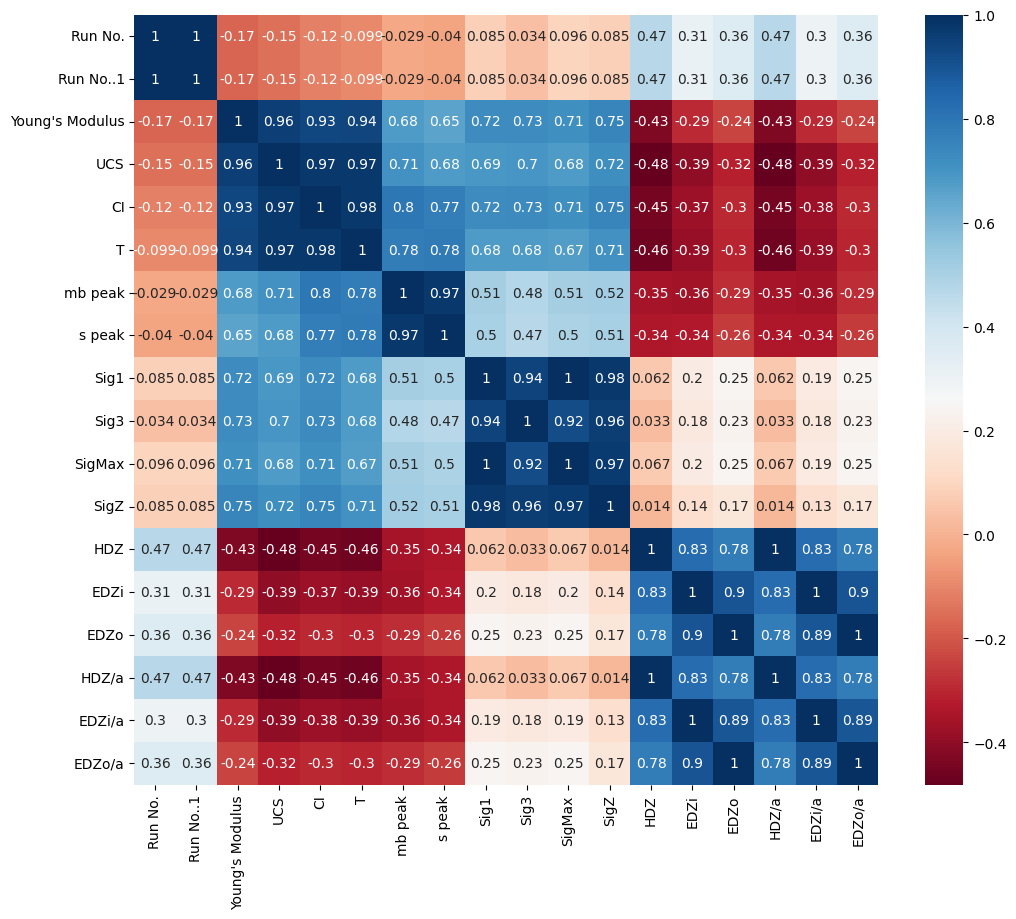

In [16]:
# Correlation matrix

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(EDZ.corr(), annot=True, cmap='RdBu')

plt.show()


# **Dummy Variable for Young's Modulus and Normalizing the data & Performing the Correlation Matrix**

In [17]:
# Reading the excel file

EDZ = pd.read_excel('/content/EDZ_input_data_Final.xlsx')

In [18]:
EDZ.columns

Index(['Run No.', 'Run No..1', 'File Name', 'Young's Modulus', 'UCS', 'CI',
       'T', 'mb peak', 's peak', 'Sig1', 'Sig3', 'SigMax', 'SigZ', 'HDZ',
       'EDZi', 'EDZo', 'HDZ/a', 'EDZi/a', 'EDZo/a'],
      dtype='object')

In [19]:
#Droping the first row (units)
EDZ.drop(0, axis=0, inplace=True)

# Create dummy variables for 'Young's Modulus'
youngs_modulus_dummies = pd.get_dummies(EDZ["Young's Modulus"], prefix='E')

# Concatenate the dummy variables with the original DataFrame
EDZ = pd.concat([EDZ, youngs_modulus_dummies], axis=1)

# Drop the original 'Young's Modulus' column
EDZ = EDZ.drop("Young's Modulus", axis=1)

EDZ

,Run No.,Run No..1,File Name,UCS,CI,T,mb peak,s peak,Sig1,Sig3,...,SigZ,HDZ,EDZi,EDZo,HDZ/a,EDZi/a,EDZo/a,E_15000,E_40000,E_75000
1,438.0,438.0,Shale_KHh1p5_plastic_UCS52,51.82,17.32,2.165,0.298704,0.012480,13.5,9,...,5.4,0.5,1.2,1.9,1.153846,1.369231,1.584615,1,0,0
2,439.0,439.0,Shale_KHh1p5_plastic_UCS19,18.77,7.56,0.945,0.522712,0.026317,13.5,9,...,5.4,0.8,2.3,4.8,1.246154,1.707692,2.476923,1,0,0
3,441.0,441.0,Shale_KHh1p5_plastic_UCS58,57.84,24.84,3.105,0.633665,0.034017,13.5,9,...,5.4,0.3,0.5,0.8,1.092308,1.153846,1.246154,1,0,0
4,442.0,442.0,Shale_KHh1p5_plastic_UCS51,50.66,18.68,2.335,0.401074,0.018486,13.5,9,...,5.4,0.5,1.2,1.75,1.153846,1.369231,1.538462,1,0,0
5,443.0,443.0,Shale_KHh1p5_plastic_UCS44,44.09,19.6,2.45,0.702810,0.039054,13.5,9,...,5.4,0.6,1.2,1.6,1.184615,1.369231,1.492308,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,NaN,NaN,Limestone_KHh1p5_plastic_UCS140,146.87,41.36,5.17,0.178662,0.006289,94,87,...,67,1.35,2.43,4.8,1.415385,1.747692,2.476923,0,1,0
422,NaN,NaN,Limestone_KHh1p5_plastic_UCS141,121.64,44.05,5.50625,0.379926,0.017198,54,23,...,20,0.75,1.4,2.47,1.230769,1.430769,1.76,0,1,0
423,NaN,NaN,Limestone_KHh1p5_plastic_UCS142,121.64,44.05,5.50625,0.379926,0.017198,63,31,...,24,0.75,1.7,2.98,1.230769,1.523077,1.916923,0,1,0
424,NaN,NaN,Limestone_KHh1p5_plastic_UCS143,121.64,44.05,5.50625,0.379926,0.017198,76,65,...,48,1.34,2.63,4.3,1.412308,1.809231,2.323077,0,1,0


In [20]:
# Rearranging the Columns

EDZ = EDZ[['Run No.', 'Run No..1', 'File Name', 'E_15000', 'E_40000', 'E_75000', 'UCS', 'CI', 'T', 'mb peak',
           's peak', 'Sig1', 'Sig3', 'SigMax', 'SigZ', 'HDZ', 'EDZi', 'EDZo', 'HDZ/a', 'EDZi/a', 'EDZo/a']]

EDZ

,Run No.,Run No..1,File Name,E_15000,E_40000,E_75000,UCS,CI,T,mb peak,...,Sig1,Sig3,SigMax,SigZ,HDZ,EDZi,EDZo,HDZ/a,EDZi/a,EDZo/a
1,438.0,438.0,Shale_KHh1p5_plastic_UCS52,1,0,0,51.82,17.32,2.165,0.298704,...,13.5,9,31.5,5.4,0.5,1.2,1.9,1.153846,1.369231,1.584615
2,439.0,439.0,Shale_KHh1p5_plastic_UCS19,1,0,0,18.77,7.56,0.945,0.522712,...,13.5,9,31.5,5.4,0.8,2.3,4.8,1.246154,1.707692,2.476923
3,441.0,441.0,Shale_KHh1p5_plastic_UCS58,1,0,0,57.84,24.84,3.105,0.633665,...,13.5,9,31.5,5.4,0.3,0.5,0.8,1.092308,1.153846,1.246154
4,442.0,442.0,Shale_KHh1p5_plastic_UCS51,1,0,0,50.66,18.68,2.335,0.401074,...,13.5,9,31.5,5.4,0.5,1.2,1.75,1.153846,1.369231,1.538462
5,443.0,443.0,Shale_KHh1p5_plastic_UCS44,1,0,0,44.09,19.6,2.45,0.702810,...,13.5,9,31.5,5.4,0.6,1.2,1.6,1.184615,1.369231,1.492308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,NaN,NaN,Limestone_KHh1p5_plastic_UCS140,0,1,0,146.87,41.36,5.17,0.178662,...,94,87,195.0,67,1.35,2.43,4.8,1.415385,1.747692,2.476923
422,NaN,NaN,Limestone_KHh1p5_plastic_UCS141,0,1,0,121.64,44.05,5.50625,0.379926,...,54,23,139.0,20,0.75,1.4,2.47,1.230769,1.430769,1.76
423,NaN,NaN,Limestone_KHh1p5_plastic_UCS142,0,1,0,121.64,44.05,5.50625,0.379926,...,63,31,158.0,24,0.75,1.7,2.98,1.230769,1.523077,1.916923
424,NaN,NaN,Limestone_KHh1p5_plastic_UCS143,0,1,0,121.64,44.05,5.50625,0.379926,...,76,65,163.0,48,1.34,2.63,4.3,1.412308,1.809231,2.323077


In [21]:
# Convert specific columns to float64
columns_to_convert = ['Run No.', 'Run No..1', 'UCS', 'CI',
       'T', 'mb peak', 's peak', 'Sig1', 'Sig3', 'SigMax', 'SigZ', 'HDZ',
       'EDZi', 'EDZo', 'HDZ/a', 'EDZi/a', 'EDZo/a', 'E_15000',
                      'E_75000', 'E_40000']
EDZ[columns_to_convert] = EDZ[columns_to_convert].astype(float)

print(EDZ.dtypes)

Run No.      float64
Run No..1    float64
File Name     object
E_15000      float64
E_40000      float64
E_75000      float64
UCS          float64
CI           float64
T            float64
mb peak      float64
s peak       float64
Sig1         float64
Sig3         float64
SigMax       float64
SigZ         float64
HDZ          float64
EDZi         float64
EDZo         float64
HDZ/a        float64
EDZi/a       float64
EDZo/a       float64
dtype: object


In [22]:
# Delete these columns: 'Run No.', 'Run No..1', 'File Name', 'HDZ', 'EDZi', 'EDZo'

EDZ.drop(['Run No.', 'Run No..1', 'File Name', 'HDZ', 'EDZi', 'EDZo', 'SigMax'], axis=1, inplace=True)


In [23]:
EDZ.columns

Index(['E_15000', 'E_40000', 'E_75000', 'UCS', 'CI', 'T', 'mb peak', 's peak',
       'Sig1', 'Sig3', 'SigZ', 'HDZ/a', 'EDZi/a', 'EDZo/a'],
      dtype='object')

In [24]:
EDZ

,E_15000,E_40000,E_75000,UCS,CI,T,mb peak,s peak,Sig1,Sig3,SigZ,HDZ/a,EDZi/a,EDZo/a
1,1.0,0.0,0.0,51.82,17.32,2.16500,0.298704,0.012480,13.5,9.0,5.4,1.153846,1.369231,1.584615
2,1.0,0.0,0.0,18.77,7.56,0.94500,0.522712,0.026317,13.5,9.0,5.4,1.246154,1.707692,2.476923
3,1.0,0.0,0.0,57.84,24.84,3.10500,0.633665,0.034017,13.5,9.0,5.4,1.092308,1.153846,1.246154
4,1.0,0.0,0.0,50.66,18.68,2.33500,0.401074,0.018486,13.5,9.0,5.4,1.153846,1.369231,1.538462
5,1.0,0.0,0.0,44.09,19.60,2.45000,0.702810,0.039054,13.5,9.0,5.4,1.184615,1.369231,1.492308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0.0,1.0,0.0,146.87,41.36,5.17000,0.178662,0.006289,94.0,87.0,67.0,1.415385,1.747692,2.476923
422,0.0,1.0,0.0,121.64,44.05,5.50625,0.379926,0.017198,54.0,23.0,20.0,1.230769,1.430769,1.760000
423,0.0,1.0,0.0,121.64,44.05,5.50625,0.379926,0.017198,63.0,31.0,24.0,1.230769,1.523077,1.916923
424,0.0,1.0,0.0,121.64,44.05,5.50625,0.379926,0.017198,76.0,65.0,48.0,1.412308,1.809231,2.323077


In [25]:


# Specify the columns you want to normalize
columns_to_normalize = ['UCS', 'CI', 'T', 'mb peak', 's peak',
                        'Sig1','Sig3', 'SigZ']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply Min-Max Scaling to the specified columns
EDZ[columns_to_normalize] = scaler.fit_transform(EDZ[columns_to_normalize])



In [26]:
EDZ

,E_15000,E_40000,E_75000,UCS,CI,T,mb peak,s peak,Sig1,Sig3,SigZ,HDZ/a,EDZi/a,EDZo/a
1,1.0,0.0,0.0,0.122485,0.059447,0.059447,0.049226,0.024099,0.000000,0.021303,0.000000,1.153846,1.369231,1.584615
2,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.122340,0.071700,0.000000,0.021303,0.000000,1.246154,1.707692,2.476923
3,1.0,0.0,0.0,0.144795,0.105250,0.105250,0.158554,0.098190,0.000000,0.021303,0.000000,1.092308,1.153846,1.246154
4,1.0,0.0,0.0,0.118186,0.067731,0.067731,0.082639,0.044762,0.000000,0.021303,0.000000,1.153846,1.369231,1.538462
5,1.0,0.0,0.0,0.093837,0.073334,0.073334,0.181122,0.115518,0.000000,0.021303,0.000000,1.184615,1.369231,1.492308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0.0,1.0,0.0,0.474743,0.205872,0.205872,0.010046,0.002803,0.363431,0.759799,0.773869,1.415385,1.747692,2.476923
422,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.182844,0.153853,0.183417,1.230769,1.430769,1.760000
423,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.223476,0.229597,0.233668,1.230769,1.523077,1.916923
424,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.282167,0.551505,0.535176,1.412308,1.809231,2.323077


In [27]:
print(EDZ.nunique())

E_15000      2
E_40000      2
E_75000      2
UCS        111
CI         108
T          118
mb peak    143
s peak     116
Sig1       123
Sig3       115
SigZ       111
HDZ/a       42
EDZi/a      94
EDZo/a     121
dtype: int64


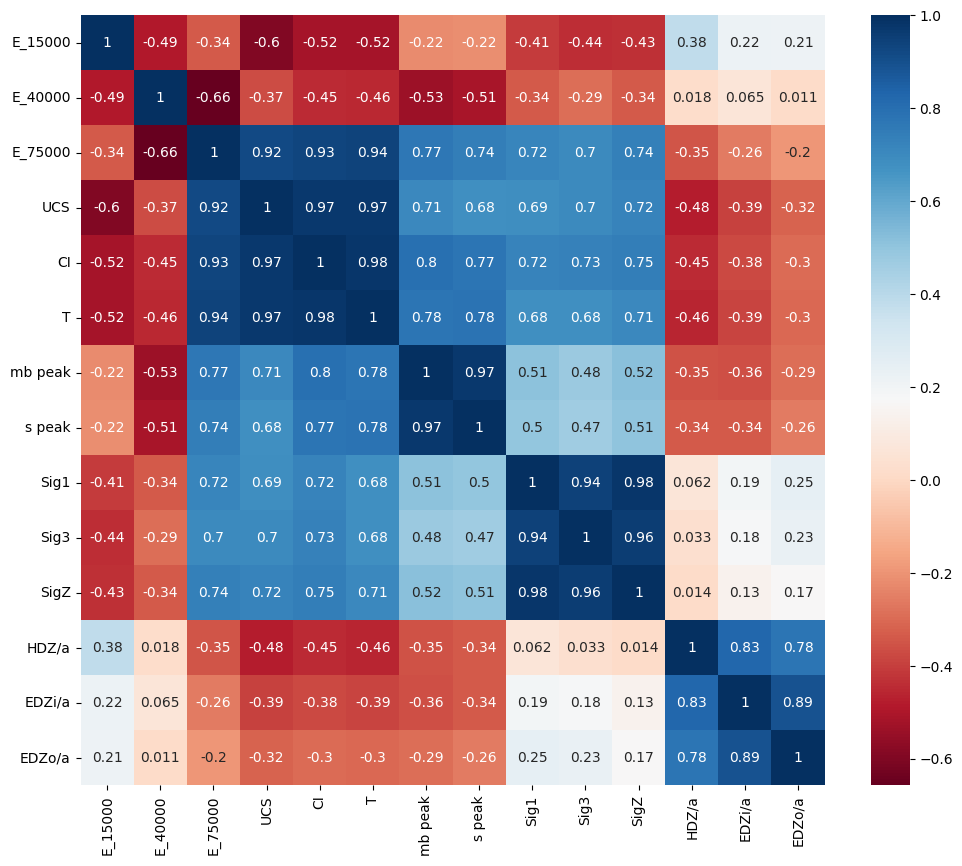

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(EDZ.corr(), annot=True, cmap='RdBu')

plt.show()

# **Splitting Data**

In [29]:
EDZ

,E_15000,E_40000,E_75000,UCS,CI,T,mb peak,s peak,Sig1,Sig3,SigZ,HDZ/a,EDZi/a,EDZo/a
1,1.0,0.0,0.0,0.122485,0.059447,0.059447,0.049226,0.024099,0.000000,0.021303,0.000000,1.153846,1.369231,1.584615
2,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.122340,0.071700,0.000000,0.021303,0.000000,1.246154,1.707692,2.476923
3,1.0,0.0,0.0,0.144795,0.105250,0.105250,0.158554,0.098190,0.000000,0.021303,0.000000,1.092308,1.153846,1.246154
4,1.0,0.0,0.0,0.118186,0.067731,0.067731,0.082639,0.044762,0.000000,0.021303,0.000000,1.153846,1.369231,1.538462
5,1.0,0.0,0.0,0.093837,0.073334,0.073334,0.181122,0.115518,0.000000,0.021303,0.000000,1.184615,1.369231,1.492308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0.0,1.0,0.0,0.474743,0.205872,0.205872,0.010046,0.002803,0.363431,0.759799,0.773869,1.415385,1.747692,2.476923
422,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.182844,0.153853,0.183417,1.230769,1.430769,1.760000
423,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.223476,0.229597,0.233668,1.230769,1.523077,1.916923
424,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.282167,0.551505,0.535176,1.412308,1.809231,2.323077


In [30]:
# Spliting the data

x_EDZ = EDZ[['E_15000','E_40000', 'E_75000','UCS','CI','T','mb peak','s peak','Sig1','Sig3','SigZ']]
y_EDZ = EDZ[['HDZ/a', 'EDZi/a', 'EDZo/a']]


In [31]:
x_EDZ

,E_15000,E_40000,E_75000,UCS,CI,T,mb peak,s peak,Sig1,Sig3,SigZ
1,1.0,0.0,0.0,0.122485,0.059447,0.059447,0.049226,0.024099,0.000000,0.021303,0.000000
2,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.122340,0.071700,0.000000,0.021303,0.000000
3,1.0,0.0,0.0,0.144795,0.105250,0.105250,0.158554,0.098190,0.000000,0.021303,0.000000
4,1.0,0.0,0.0,0.118186,0.067731,0.067731,0.082639,0.044762,0.000000,0.021303,0.000000
5,1.0,0.0,0.0,0.093837,0.073334,0.073334,0.181122,0.115518,0.000000,0.021303,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
421,0.0,1.0,0.0,0.474743,0.205872,0.205872,0.010046,0.002803,0.363431,0.759799,0.773869
422,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.182844,0.153853,0.183417
423,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.223476,0.229597,0.233668
424,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.282167,0.551505,0.535176


In [32]:
y_EDZ

,HDZ/a,EDZi/a,EDZo/a
1,1.153846,1.369231,1.584615
2,1.246154,1.707692,2.476923
3,1.092308,1.153846,1.246154
4,1.153846,1.369231,1.538462
5,1.184615,1.369231,1.492308
...,...,...,...
421,1.415385,1.747692,2.476923
422,1.230769,1.430769,1.760000
423,1.230769,1.523077,1.916923
424,1.412308,1.809231,2.323077


In [33]:
x_train_EDZ, x_test_EDZ, y_train_EDZ, y_test_EDZ = train_test_split(x_EDZ, y_EDZ, test_size=0.2, random_state=7)

In [34]:
print(x_train_EDZ.shape)
print(x_test_EDZ.shape)
print(y_train_EDZ.shape)
print(y_test_EDZ.shape)

(340, 11)
(85, 11)
(340, 3)
(85, 3)


In [35]:
#Combining x & y training sets for data augmentation
x_y_training = pd.concat([x_train_EDZ, y_train_EDZ], axis=1)
x_y_training.shape

(340, 14)

# **Data Augmentation**

In [36]:

# Number of augmented samples you want to generate
num_augmented_samples = 1

# Initialize an empty DataFrame to store augmented data
augmented_data = pd.DataFrame()

# Define the range for random noise and scaling
noise_range = 0.02
scaling_range = 0.1

# Loop to generate augmented samples
for values in range(num_augmented_samples):
    # Copy the original data
    augmented_sample = x_y_training.copy()

# Add random noise to the specified columns
    columns_to_augment = ['E_15000','E_40000', 'E_75000','UCS','CI','T','mb peak','s peak','Sig1','Sig3','SigZ', 'HDZ/a', 'EDZi/a', 'EDZo/a']
    augmented_sample[columns_to_augment] += np.random.uniform(-noise_range, noise_range, size=len(columns_to_augment))

    # Multiply by a random scaling factor for the specified columns
    augmented_sample[columns_to_augment] *= np.random.uniform(1 - scaling_range, 1 + scaling_range, size=len(columns_to_augment))

    # Append the augmented sample to the DataFrame
    augmented_data = augmented_data.append(augmented_sample, ignore_index=True)

# Concatenate the original data with the augmented data
augmented_EDZ = pd.concat([x_y_training, augmented_data], ignore_index=True)

# Shuffle the rows to mix original and augmented data
augmented_EDZ_training = augmented_EDZ.sample(frac=1).reset_index(drop=True)

In [37]:
augmented_EDZ_training

,E_15000,E_40000,E_75000,UCS,CI,T,mb peak,s peak,Sig1,Sig3,SigZ,HDZ/a,EDZi/a,EDZo/a
0,1.000000,0.000000,0.000000,0.130638,0.084176,0.084176,0.113609,0.065576,0.067269,0.053494,0.023241,1.412308,1.695385,2.236923
1,0.017920,1.090054,-0.015551,0.251514,0.122358,0.256127,0.035448,0.060008,0.062541,0.071185,0.085276,1.238205,1.470269,1.971960
2,0.017920,-0.008225,0.937211,0.791050,0.595805,0.647820,0.314219,0.211475,0.356429,0.391498,0.432788,1.007450,1.259037,1.679306
3,0.017920,1.090054,-0.015551,0.367479,0.200068,0.215983,0.118835,0.074134,0.072672,0.133772,0.097256,1.036295,1.289213,1.549237
4,0.017920,1.090054,-0.015551,0.232632,0.105169,0.119724,0.072373,0.050208,0.073202,0.082804,0.097882,1.223783,1.470269,2.069511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,0.000000,0.000000,1.000000,0.847608,0.702826,0.702826,0.271910,0.190737,0.605147,0.867355,0.673568,1.153846,1.584615,1.953846
676,0.000000,0.000000,1.000000,0.808768,0.739676,0.739676,0.372798,0.283121,1.000000,0.740863,0.610553,1.504615,1.895385,3.892308
677,0.017920,-0.008225,0.937211,0.819959,0.562587,0.611572,0.230005,0.148210,0.214550,0.236863,0.265022,0.993028,1.259037,1.484203
678,0.017920,-0.008225,0.937211,0.882936,0.665612,0.723994,0.313468,0.210888,0.356429,0.391498,0.432788,1.122828,1.349565,1.679306


In [38]:
# After augmentation then deviding the EDZ training data to x and y
x_train_EDZ = augmented_EDZ_training[['E_15000','E_40000', 'E_75000','UCS','CI','T','mb peak','s peak','Sig1','Sig3','SigZ']]
y_train_EDZ = augmented_EDZ_training[['HDZ/a', 'EDZi/a', 'EDZo/a']]

In [39]:
print(x_train_EDZ.shape)
print(x_test_EDZ.shape)
print(y_train_EDZ.shape)
print(y_test_EDZ.shape)

(680, 11)
(85, 11)
(680, 3)
(85, 3)


# **Regression Models With All the Features**

In [40]:
# # Create an MLP regression model

# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another appropriate metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to your training data
# gridsearch_MLPReg.fit(x_train_EDZ, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions = best_model.predict(x_test_EDZ)

# # Evaluate the performance using an appropriate metric
# test_score = r2_score(y_test_EDZ, predictions)
# print("R^2 Score on Test Data:", test_score)

'''
Best Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (5, 5), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.8613825595516911

'''

"\nBest Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (5, 5), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.8613825595516911\n\n"

In [41]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(5, 5),
    activation='relu',
    alpha=0.01,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to your training data
best_mlp_multioutput_regressor.fit(x_train_EDZ, y_train_EDZ)

# Make predictions on the test data
predictions = best_mlp_multioutput_regressor.predict(x_test_EDZ)

# Evaluate the performance using the R^2 score
test_score = r2_score(y_test_EDZ, predictions)
print("R^2 Score on Test Data:", test_score)


# Calculate and print the mean absolute error
test_score_mae = mean_absolute_error(y_test_EDZ, predictions)
print("\nMean Absolute Error on Test Data:", test_score_mae)

R^2 Score on Test Data: 0.8219050330578394

Mean Absolute Error on Test Data: 0.06396320176798635


**The best params when the features are :Young's Modulus,	CI,	mb peak,	s peak,	Sig1,	Sig3**
Best Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.1, 'estimator__hidden_layer_sizes': (4, 3), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.7867586285711656

## Visualizing Predictions VS. Actual Values




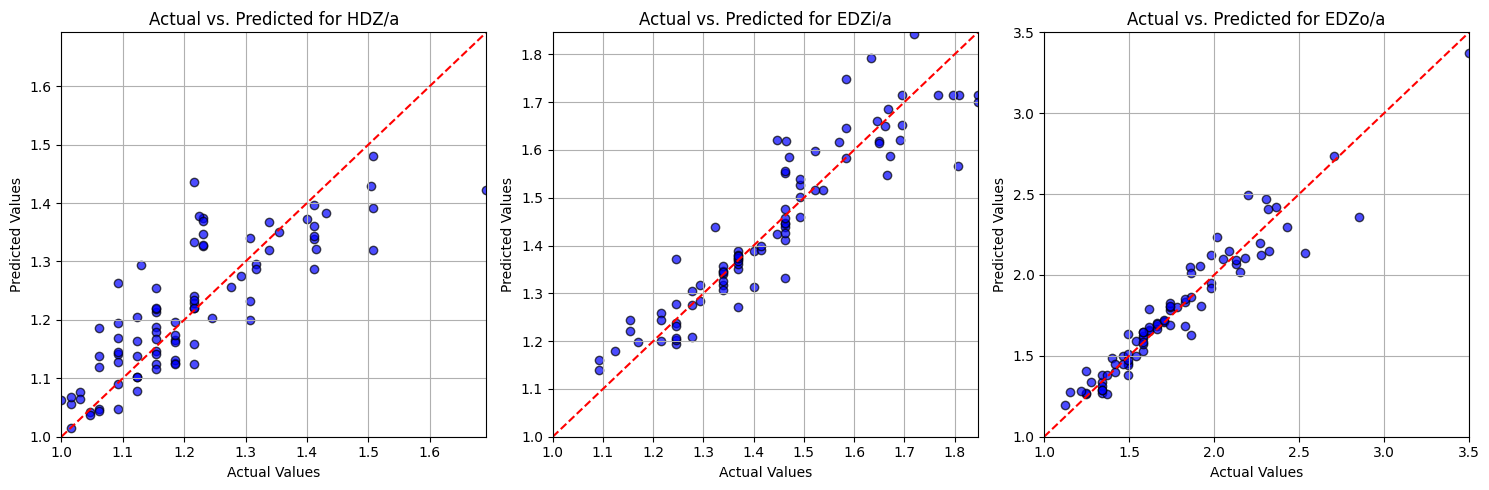

In [42]:
# Make predictions on the test data using the best model
# predictions = best_model.predict(x_test_EDZ)

# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']

plt.figure(figsize=(15, 5))

for i, target in enumerate(targets):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_EDZ[target], predictions[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'Actual vs. Predicted for {target}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)



    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)
    if i==2:
      plt.xlim(1, 3.5)
      plt.ylim(1, 3.5)
    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Ensure equal axes
    # plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

##Residual Analysis

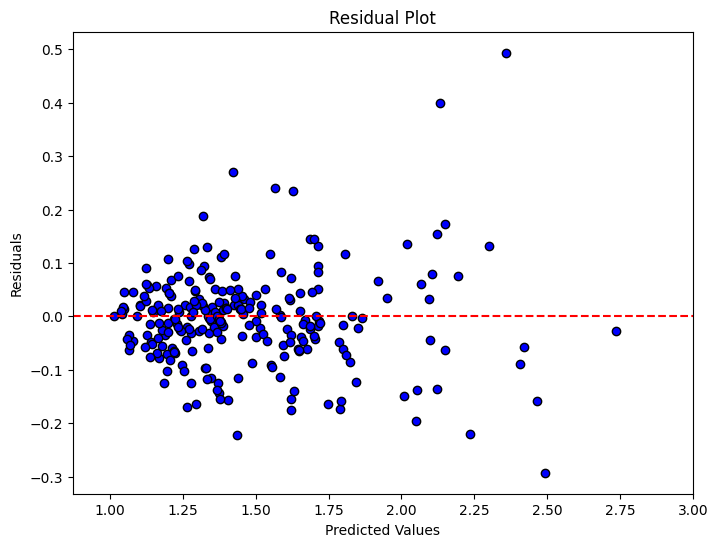

In [43]:
residuals = y_test_EDZ - predictions
plt.figure(figsize=(8, 6))
plt.scatter(predictions, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.xlim(None,3)
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# **Regression Model without Rock Material Properties**

In [44]:
# Dropping
x_train_EDZ_Rock_Mat_Prop = x_train_EDZ.drop(['E_15000','E_40000','E_75000', 'UCS', 'CI', 'T'], axis=1, inplace=False)
x_test_EDZ_Rock_Mat_Prop = x_test_EDZ.drop(['E_15000','E_40000','E_75000', 'UCS', 'CI', 'T'], axis=1, inplace=False)

In [45]:
x_train_EDZ_Rock_Mat_Prop

,mb peak,s peak,Sig1,Sig3,SigZ
0,0.113609,0.065576,0.067269,0.053494,0.023241
1,0.035448,0.060008,0.062541,0.071185,0.085276
2,0.314219,0.211475,0.356429,0.391498,0.432788
3,0.118835,0.074134,0.072672,0.133772,0.097256
4,0.072373,0.050208,0.073202,0.082804,0.097882
...,...,...,...,...,...
675,0.271910,0.190737,0.605147,0.867355,0.673568
676,0.372798,0.283121,1.000000,0.740863,0.610553
677,0.230005,0.148210,0.214550,0.236863,0.265022
678,0.313468,0.210888,0.356429,0.391498,0.432788


In [46]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to your training data
# gridsearch_MLPReg.fit(x_train_EDZ_Rock_Mat_Prop, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_Rock_Mat_Prop = best_model.predict(x_test_EDZ_Rock_Mat_Prop)

# # Evaluate the performance using an appropriate metric
# test_score_Rock_Mat_Prop = r2_score(y_test_EDZ, predictions_Rock_Mat_Prop)
# print("R^2 Score on Test Data:", test_score_Rock_Mat_Prop)


'''
Best Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (5, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.4931681214437324
'''

"\nBest Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (5, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.4931681214437324\n"

In [47]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(5, 6),
    activation='relu',
    alpha=0.0001,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to your training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_Rock_Mat_Prop, y_train_EDZ)

# Make predictions on the test data
predictions_Rock_Mat_Prop = best_mlp_multioutput_regressor.predict(x_test_EDZ_Rock_Mat_Prop)

# Evaluate the performance using the R^2 score
test_score_Rock_Mat_Prop = r2_score(y_test_EDZ, predictions_Rock_Mat_Prop)
print("R^2 Score on Test Data:", test_score_Rock_Mat_Prop)

# Calculate and print the mean absolute error
test_score_mae_Rock_Mat_Prop = mean_absolute_error(y_test_EDZ, predictions_Rock_Mat_Prop)
print("\nMean Absolute Error on Test Data:", test_score_mae_Rock_Mat_Prop)

R^2 Score on Test Data: 0.5308514983428347

Mean Absolute Error on Test Data: 0.12674101437619675


## Visualizing Predictions VS. Actual Values


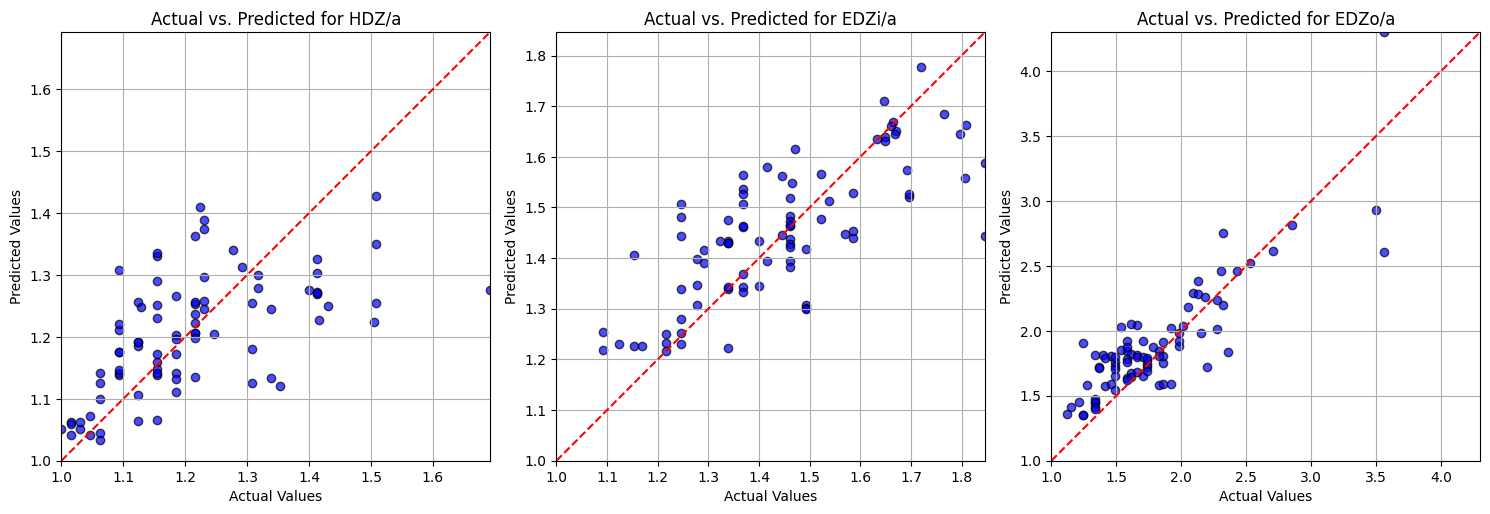

In [48]:

# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']

plt.figure(figsize=(15, 5))

for i, target in enumerate(targets):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_EDZ[target], predictions_Rock_Mat_Prop[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'Actual vs. Predicted for {target}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_Rock_Mat_Prop[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

## Residual Analysis

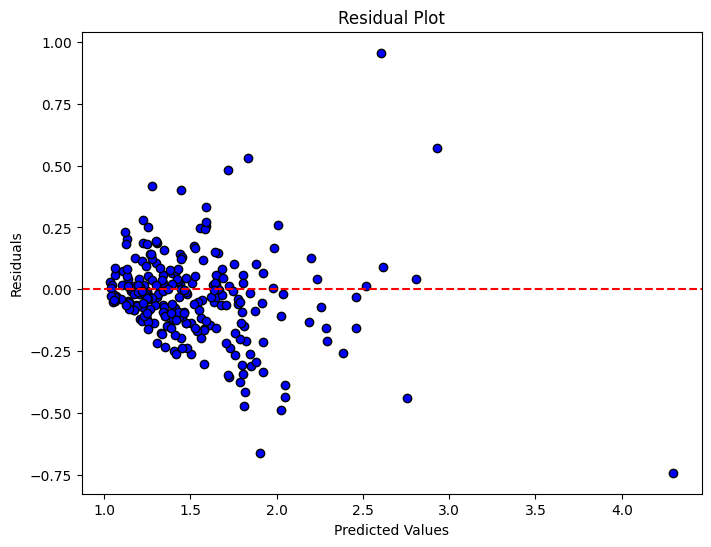

In [49]:
residuals = y_test_EDZ - predictions_Rock_Mat_Prop
plt.figure(figsize=(8, 6))
plt.scatter(predictions_Rock_Mat_Prop, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# **Regression Model without Hoek-Brown Parameters**





In [50]:
# Dropping
x_train_EDZ_HB_Comp = x_train_EDZ.drop(['mb peak', 's peak'], axis=1, inplace=False)
x_test_EDZ_HB_Comp = x_test_EDZ.drop(['mb peak', 's peak'], axis=1, inplace=False)

In [51]:
x_train_EDZ_HB_Comp

,E_15000,E_40000,E_75000,UCS,CI,T,Sig1,Sig3,SigZ
0,1.000000,0.000000,0.000000,0.130638,0.084176,0.084176,0.067269,0.053494,0.023241
1,0.017920,1.090054,-0.015551,0.251514,0.122358,0.256127,0.062541,0.071185,0.085276
2,0.017920,-0.008225,0.937211,0.791050,0.595805,0.647820,0.356429,0.391498,0.432788
3,0.017920,1.090054,-0.015551,0.367479,0.200068,0.215983,0.072672,0.133772,0.097256
4,0.017920,1.090054,-0.015551,0.232632,0.105169,0.119724,0.073202,0.082804,0.097882
...,...,...,...,...,...,...,...,...,...
675,0.000000,0.000000,1.000000,0.847608,0.702826,0.702826,0.605147,0.867355,0.673568
676,0.000000,0.000000,1.000000,0.808768,0.739676,0.739676,1.000000,0.740863,0.610553
677,0.017920,-0.008225,0.937211,0.819959,0.562587,0.611572,0.214550,0.236863,0.265022
678,0.017920,-0.008225,0.937211,0.882936,0.665612,0.723994,0.356429,0.391498,0.432788


In [52]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to your training data
# gridsearch_MLPReg.fit(x_train_EDZ_HB_Comp, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_HB_Comp = best_model.predict(x_test_EDZ_HB_Comp)

# # Evaluate the performance using an appropriate metric
# test_score_HB_Comp = r2_score(y_test_EDZ, predictions_HB_Comp)
# print("R^2 Score on Test Data:", test_score_HB_Comp)



'''
Best Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (5, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.8506747726571261

'''

"\nBest Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (5, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.8506747726571261\n\n"

In [53]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(5, 6),
    activation='relu',
    alpha=0.01,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to your training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_HB_Comp, y_train_EDZ)

# Make predictions on the test data
predictions_HB_Comp = best_mlp_multioutput_regressor.predict(x_test_EDZ_HB_Comp)

# Evaluate the performance using the R^2 score
test_score_HB_Comp = r2_score(y_test_EDZ, predictions_HB_Comp)
print("R^2 Score on Test Data:", test_score_HB_Comp)

# Calculate and print the mean absolute error
test_score_mae_HB_Comp = mean_absolute_error(y_test_EDZ, predictions_HB_Comp)
print("\nMean Absolute Error on Test Data:", test_score_mae_HB_Comp)

R^2 Score on Test Data: 0.8311680644556035

Mean Absolute Error on Test Data: 0.06472846257527258


## Visualizing Predictions VS. Actual Values

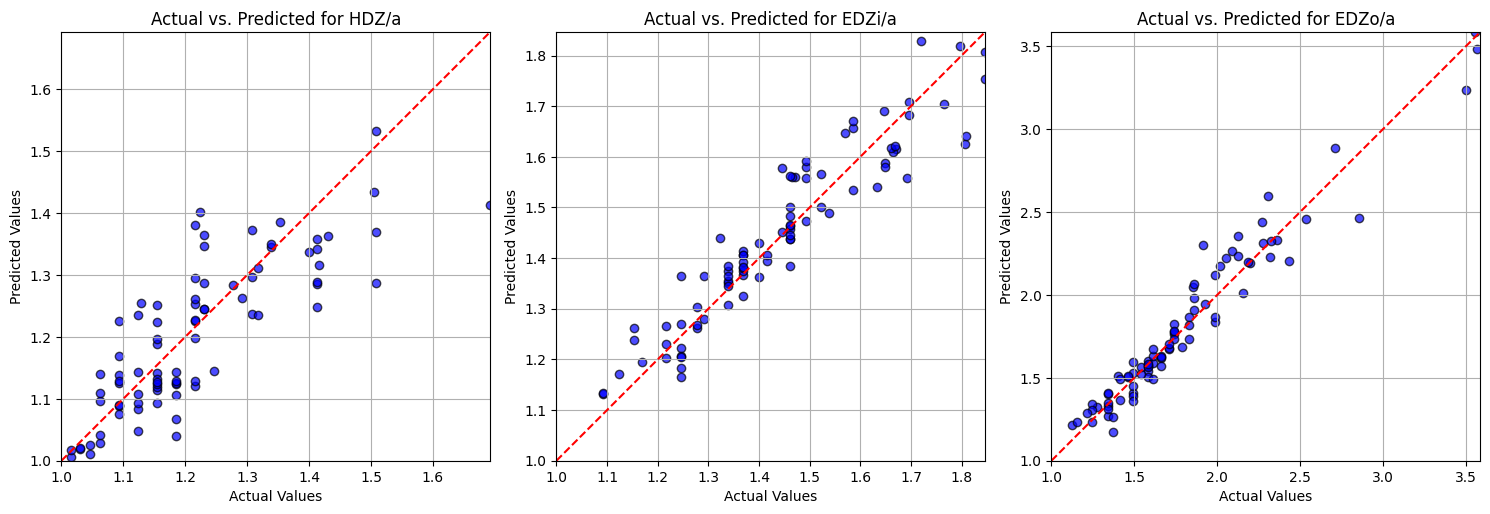

In [54]:

# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']

plt.figure(figsize=(15, 5))

for i, target in enumerate(targets):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_EDZ[target], predictions_HB_Comp[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'Actual vs. Predicted for {target}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_HB_Comp[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

## Residual Analysis

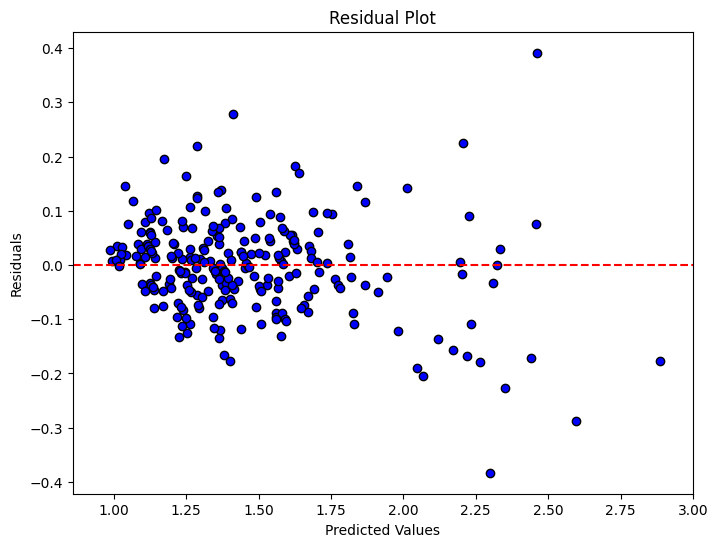

In [55]:
residuals = y_test_EDZ - predictions_HB_Comp
plt.figure(figsize=(8, 6))
plt.scatter(predictions_HB_Comp, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlim(None,3)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# **Regression Model without Stress Components**

In [56]:
# Dropping
x_train_EDZ_stress = x_train_EDZ.drop(['Sig1', 'Sig3', 'SigZ'], axis=1, inplace=False)
x_test_EDZ_stress = x_test_EDZ.drop(['Sig1', 'Sig3', 'SigZ'], axis=1, inplace=False)

In [57]:
x_train_EDZ_stress

,E_15000,E_40000,E_75000,UCS,CI,T,mb peak,s peak
0,1.000000,0.000000,0.000000,0.130638,0.084176,0.084176,0.113609,0.065576
1,0.017920,1.090054,-0.015551,0.251514,0.122358,0.256127,0.035448,0.060008
2,0.017920,-0.008225,0.937211,0.791050,0.595805,0.647820,0.314219,0.211475
3,0.017920,1.090054,-0.015551,0.367479,0.200068,0.215983,0.118835,0.074134
4,0.017920,1.090054,-0.015551,0.232632,0.105169,0.119724,0.072373,0.050208
...,...,...,...,...,...,...,...,...
675,0.000000,0.000000,1.000000,0.847608,0.702826,0.702826,0.271910,0.190737
676,0.000000,0.000000,1.000000,0.808768,0.739676,0.739676,0.372798,0.283121
677,0.017920,-0.008225,0.937211,0.819959,0.562587,0.611572,0.230005,0.148210
678,0.017920,-0.008225,0.937211,0.882936,0.665612,0.723994,0.313468,0.210888


In [58]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to your training data
# gridsearch_MLPReg.fit(x_train_EDZ_stress, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_stress = best_model.predict(x_test_EDZ_stress)

# # Evaluate the performance using an appropriate metric
# test_score_stress = r2_score(y_test_EDZ, predictions_stress)
# print("R^2 Score on Test Data:", test_score_stress)

'''
Best Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (4, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.1856979646456387
'''

"\nBest Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (4, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.1856979646456387\n"

In [59]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(4, 6),
    activation='relu',
    alpha=0.01,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to your training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_stress, y_train_EDZ)

# Make predictions on the test data
predictions_stress = best_mlp_multioutput_regressor.predict(x_test_EDZ_stress)

# Evaluate the performance using the R^2 score
test_score_stress = r2_score(y_test_EDZ, predictions_stress)
print("R^2 Score on Test Data:", test_score_stress)

# Calculate and print the mean absolute error
test_score_mae_stress = mean_absolute_error(y_test_EDZ, predictions_stress)
print("\nMean Absolute Error on Test Data:", test_score_mae_stress)

R^2 Score on Test Data: 0.17457573211668934

Mean Absolute Error on Test Data: 0.18578022121806861


## Visualizing Predictions VS. Actual Values


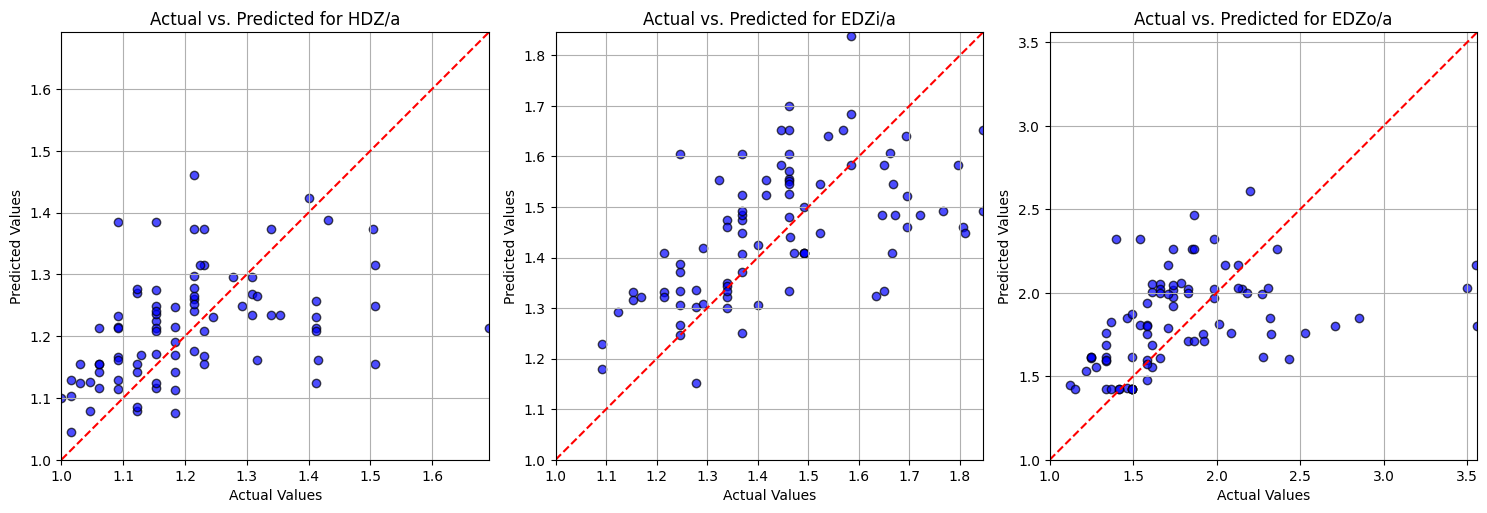

In [60]:

# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']

plt.figure(figsize=(15, 5))

for i, target in enumerate(targets):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_EDZ[target], predictions_stress[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'Actual vs. Predicted for {target}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_stress[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

## Residual Analysis

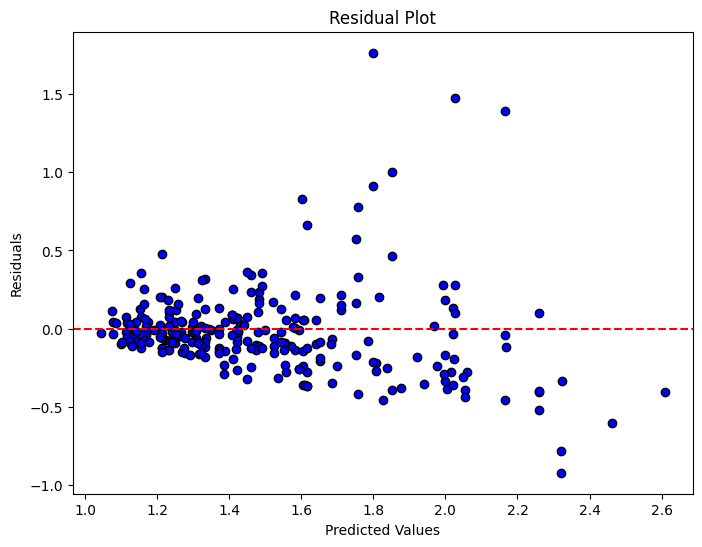

In [61]:
residuals = y_test_EDZ - predictions_stress
plt.figure(figsize=(8, 6))
plt.scatter(predictions_stress, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# **Plotting $R^2$ & $MAE$  for different MLPS**


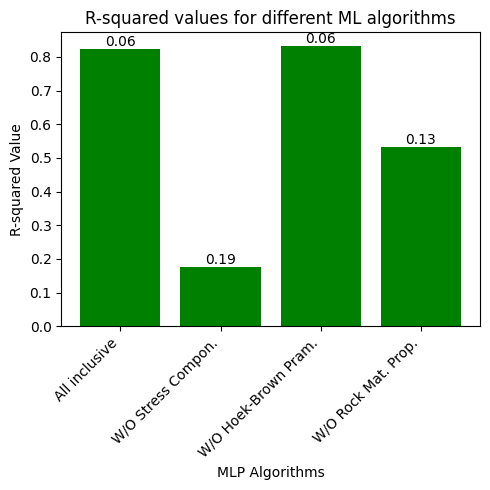

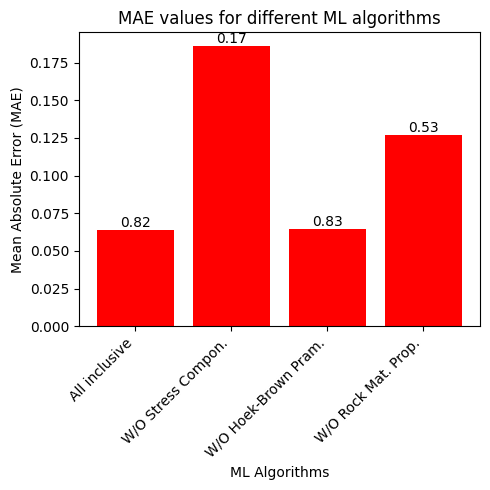

In [62]:

# Your MAE and R-squared values
mae_values = (test_score_mae, test_score_mae_stress,
              test_score_mae_HB_Comp, test_score_mae_Rock_Mat_Prop)

r_squared_values = (test_score, test_score_stress,
                    test_score_HB_Comp, test_score_Rock_Mat_Prop)

# X-axis values
x_eval = np.array([1, 2, 3, 4])
my_xticks = ['All inclusive', 'W/O Stress Compon.', 'W/O Hoek-Brown Pram.', 'W/O Rock Mat. Prop.']


# Plotting R-squared values
plt.figure(figsize=(5, 5))
bars = plt.bar(x_eval, r_squared_values, color='green')
plt.xticks(x_eval, my_xticks, rotation=45, ha='right')
plt.xlabel('MLP Algorithms')
plt.ylabel('R-squared Value')
plt.title('R-squared values for different ML algorithms')



# Displaying numeric values on top of the bars
for bar, value in zip(bars, mae_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()


# Plotting MAE values
plt.figure(figsize=(5, 5))
bars = plt.bar(x_eval, mae_values, color='red')
plt.xticks(x_eval, my_xticks, rotation=45, ha='right')
plt.xlabel('ML Algorithms')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE values for different ML algorithms')

# Displaying numeric values on top of the bars
for bar, value in zip(bars, r_squared_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [63]:
# This shows that Hoek Brown parameters are not needed for MLP Models

# **Performing Variance Inflation Factor (VIF)**

## For all the variables without removing any

In [64]:

# Function to calculate VIF for a group of features
EDZ_All = EDZ.drop(['HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)

def calculate_vif(data_frame, features):
    X = data_frame[features]
    vif_data = pd.DataFrame()
    vif_data["Variable"] = features
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Groups of variables
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'UCS', 'CI', 'T']
hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'Sig3', 'SigZ']

# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_All, rock_material_properties)
vif_hoek_brown = calculate_vif(EDZ_All, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_All, stress_components)

print("VIF for Rock Material Properties:")
print(vif_rock_material)

print("\nVIF for Hoek-Brown Parameters:")
print(vif_hoek_brown)

print("\nVIF for Stress Components:")
print(vif_stress_components)


VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.462387
1  E_40000  11.838381
2  E_75000  45.248849
3      UCS  32.234554
4       CI  27.168076
5        T  30.256351

VIF for Hoek-Brown Parameters:
  Variable        VIF
0  mb peak  32.288125
1   s peak  32.288125

VIF for Stress Components:
  Variable        VIF
0     Sig1  42.244416
1     Sig3  24.349858
2     SigZ  58.225123


In [65]:
EDZ_All

,E_15000,E_40000,E_75000,UCS,CI,T,mb peak,s peak,Sig1,Sig3,SigZ
1,1.0,0.0,0.0,0.122485,0.059447,0.059447,0.049226,0.024099,0.000000,0.021303,0.000000
2,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.122340,0.071700,0.000000,0.021303,0.000000
3,1.0,0.0,0.0,0.144795,0.105250,0.105250,0.158554,0.098190,0.000000,0.021303,0.000000
4,1.0,0.0,0.0,0.118186,0.067731,0.067731,0.082639,0.044762,0.000000,0.021303,0.000000
5,1.0,0.0,0.0,0.093837,0.073334,0.073334,0.181122,0.115518,0.000000,0.021303,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
421,0.0,1.0,0.0,0.474743,0.205872,0.205872,0.010046,0.002803,0.363431,0.759799,0.773869
422,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.182844,0.153853,0.183417
423,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.223476,0.229597,0.233668
424,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.282167,0.551505,0.535176


In [66]:
for column in EDZ_All.columns:
        vif = variance_inflation_factor(EDZ.values, EDZ.columns.get_loc(column))
        print(f"VIF for {column}: {vif}")

# These values would be the features for the first ML model

VIF for E_15000: 64.30120490733408
VIF for E_40000: 171.31907704854115
VIF for E_75000: 189.05354240623276
VIF for UCS: 62.41039959841887
VIF for CI: 57.58806926195232
VIF for T: 77.9354981348211
VIF for mb peak: 41.80871580208876
VIF for s peak: 46.85629657417755
VIF for Sig1: 30.331437096439437
VIF for Sig3: 20.46810312988884
VIF for SigZ: 44.83824349305532


## VIF for Rock Material Properties

###Removing Young's modulus One Hot-Encoding values (all three of them)

In [67]:
EDZ_E = EDZ.drop(['E_15000', 'E_40000', 'E_75000', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
rock_material_properties = ['UCS', 'CI', 'T']
hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'Sig3', 'SigZ']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_E, rock_material_properties)
vif_hoek_brown = calculate_vif(EDZ_E, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_E, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Hoek-Brown Parameters:")
print(vif_hoek_brown)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0      UCS  46.006616
1       CI  66.806606
2        T  67.844973

VIF for Hoek-Brown Parameters:
  Variable        VIF
0  mb peak  32.288125
1   s peak  32.288125

VIF for Stress Components:
  Variable        VIF
0     Sig1  42.244416
1     Sig3  24.349858
2     SigZ  58.225123


In [68]:
for column in EDZ_E.columns:
        vif1 = variance_inflation_factor(EDZ_E.values, EDZ_E.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")
# By removing Young modulus VIF values increase for other features so it's evident that removing Young's modulus is not advisable

VIF for UCS: 124.79489860020409
VIF for CI: 85.14834762267938
VIF for T: 153.5926815625034
VIF for mb peak: 97.74285923893447
VIF for s peak: 94.49274132343015
VIF for Sig1: 44.255490526107295
VIF for Sig3: 29.582779833238817
VIF for SigZ: 61.37413455922806


### Removing UCS




In [69]:
EDZ_UCS = EDZ.drop(['UCS', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'CI', 'T']
hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'Sig3', 'SigZ']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_UCS, rock_material_properties)
vif_hoek_brown = calculate_vif(EDZ_UCS, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_UCS, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Hoek-Brown Parameters:")
print(vif_hoek_brown)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.228390
1  E_40000   6.244696
2  E_75000  34.851882
3       CI  22.465974
4        T  26.719592

VIF for Hoek-Brown Parameters:
  Variable        VIF
0  mb peak  32.288125
1   s peak  32.288125

VIF for Stress Components:
  Variable        VIF
0     Sig1  42.244416
1     Sig3  24.349858
2     SigZ  58.225123


In [70]:
for column in EDZ_UCS.columns:
        vif1 = variance_inflation_factor(EDZ_UCS.values, EDZ_UCS.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

# After comparing VIFs for when UCS is removed with the VIF when all the features are present, it shows VIFS are declining so it is fine to remove this feature if we want to (Highest decline)

VIF for E_15000: 3.0732287422814397
VIF for E_40000: 14.045647939904915
VIF for E_75000: 59.737542500084494
VIF for CI: 39.41543365532909
VIF for T: 52.26529797040372
VIF for mb peak: 35.08530222560701
VIF for s peak: 32.99126008692857
VIF for Sig1: 22.106808090845377
VIF for Sig3: 15.458175006583286
VIF for SigZ: 32.28504885406943


### Removing CI


In [71]:
EDZ_CI = EDZ.drop(['CI', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'UCS', 'T']
hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'Sig3', 'SigZ']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_CI, rock_material_properties)
vif_hoek_brown = calculate_vif(EDZ_CI, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_CI, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Hoek-Brown Parameters:")
print(vif_hoek_brown)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.456410
1  E_40000  11.706151
2  E_75000  45.220827
3      UCS  26.655574
4        T  23.975573

VIF for Hoek-Brown Parameters:
  Variable        VIF
0  mb peak  32.288125
1   s peak  32.288125

VIF for Stress Components:
  Variable        VIF
0     Sig1  42.244416
1     Sig3  24.349858
2     SigZ  58.225123


In [72]:
for column in EDZ_CI.columns:
        vif1 = variance_inflation_factor(EDZ_CI.values, EDZ_CI.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

# Does not make that much difference for other VIFS when deleting CI

VIF for E_15000: 2.5685514308642206
VIF for E_40000: 14.91372203765068
VIF for E_75000: 60.30286572163587
VIF for UCS: 49.560400386889135
VIF for T: 67.6028496249274
VIF for mb peak: 37.10630840884924
VIF for s peak: 44.91636060518134
VIF for Sig1: 22.790729608261792
VIF for Sig3: 13.270628095210187
VIF for SigZ: 32.163724218431604


In [73]:
EDZ_CI.columns

Index(['E_15000', 'E_40000', 'E_75000', 'UCS', 'T', 'mb peak', 's peak',
       'Sig1', 'Sig3', 'SigZ'],
      dtype='object')

### Removing T


In [74]:
EDZ_T = EDZ.drop(['T', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'UCS', 'CI']
hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'Sig3', 'SigZ']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_T, rock_material_properties)
vif_hoek_brown = calculate_vif(EDZ_T, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_T, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Hoek-Brown Parameters:")
print(vif_hoek_brown)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.459622
1  E_40000  11.793914
2  E_75000  42.842463
3      UCS  28.466557
4       CI  21.528379

VIF for Hoek-Brown Parameters:
  Variable        VIF
0  mb peak  32.288125
1   s peak  32.288125

VIF for Stress Components:
  Variable        VIF
0     Sig1  42.244416
1     Sig3  24.349858
2     SigZ  58.225123


In [75]:
for column in EDZ_T.columns:
        vif1 = variance_inflation_factor(EDZ_T.values, EDZ_T.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

# By comparing this VIF with the VIF for all the features, it shows a bit of decline so it is fine to remove this feature if we want to (but does not make that much different if we keep it or remove it)

VIF for E_15000: 3.081938900121349
VIF for E_40000: 17.206794238410378
VIF for E_75000: 54.56090651294481
VIF for UCS: 41.60146334562269
VIF for CI: 42.7948671361313
VIF for mb peak: 22.18110746925538
VIF for s peak: 20.440433771619198
VIF for Sig1: 22.96492359281972
VIF for Sig3: 15.213185730798877
VIF for SigZ: 33.62244537667484


### Removing UCS & CI


In [76]:
EDZ_UCS_CI = EDZ.drop(['UCS', 'CI', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'T']
hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'Sig3', 'SigZ']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_UCS_CI, rock_material_properties)
vif_hoek_brown = calculate_vif(EDZ_UCS_CI, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_UCS_CI, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Hoek-Brown Parameters:")
print(vif_hoek_brown)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.209816
1  E_40000   5.779392
2  E_75000  32.098809
3        T  13.641709

VIF for Hoek-Brown Parameters:
  Variable        VIF
0  mb peak  32.288125
1   s peak  32.288125

VIF for Stress Components:
  Variable        VIF
0     Sig1  42.244416
1     Sig3  24.349858
2     SigZ  58.225123


In [77]:
for column in EDZ_UCS_CI.columns:
        vif1 = variance_inflation_factor(EDZ_UCS_CI.values, EDZ_UCS_CI.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

VIF for E_15000: 2.5462839372696773
VIF for E_40000: 12.8864543724762
VIF for E_75000: 58.09147914539068
VIF for T: 22.01994275858838
VIF for mb peak: 25.048344541903372
VIF for s peak: 26.238923058209156
VIF for Sig1: 22.10334792440663
VIF for Sig3: 13.189983960545796
VIF for SigZ: 31.657165402401546


### Removing UCS & T

In [78]:
EDZ_UCS_T = EDZ.drop(['UCS', 'T', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'CI']
hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'Sig3', 'SigZ']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_UCS_T, rock_material_properties)
vif_hoek_brown = calculate_vif(EDZ_UCS_T, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_UCS_T, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Hoek-Brown Parameters:")
print(vif_hoek_brown)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.174591
1  E_40000   5.067764
2  E_75000  26.877773
3       CI  11.470021

VIF for Hoek-Brown Parameters:
  Variable        VIF
0  mb peak  32.288125
1   s peak  32.288125

VIF for Stress Components:
  Variable        VIF
0     Sig1  42.244416
1     Sig3  24.349858
2     SigZ  58.225123


In [79]:
for column in EDZ_UCS_T.columns:
        vif1 = variance_inflation_factor(EDZ_UCS_T.values, EDZ_UCS_T.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

VIF for E_15000: 2.187027003156598
VIF for E_40000: 6.738534216541816
VIF for E_75000: 30.88846370281339
VIF for CI: 16.606154113705905
VIF for mb peak: 22.177238241045647
VIF for s peak: 19.62564354584789
VIF for Sig1: 21.93172559983909
VIF for Sig3: 14.399080944866661
VIF for SigZ: 31.81119862456388


### Removing UCS, CI, & T

In [80]:
EDZ_UCS_CI_T = EDZ.drop(['UCS', 'CI', 'T', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
rock_material_properties = ['E_15000', 'E_40000', 'E_75000']
hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'Sig3', 'SigZ']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_UCS_CI_T, rock_material_properties)
vif_hoek_brown = calculate_vif(EDZ_UCS_CI_T, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_UCS_CI_T, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Hoek-Brown Parameters:")
print(vif_hoek_brown)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable  VIF
0  E_15000  1.0
1  E_40000  1.0
2  E_75000  1.0

VIF for Hoek-Brown Parameters:
  Variable        VIF
0  mb peak  32.288125
1   s peak  32.288125

VIF for Stress Components:
  Variable        VIF
0     Sig1  42.244416
1     Sig3  24.349858
2     SigZ  58.225123


In [81]:
for column in EDZ_UCS_CI_T.columns:
        vif1 = variance_inflation_factor(EDZ_UCS_CI_T.values, EDZ_UCS_CI_T.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

VIF for E_15000: 2.1867997691644323
VIF for E_40000: 4.460450264402722
VIF for E_75000: 12.241072216388229
VIF for mb peak: 21.72804142067678
VIF for s peak: 19.54652262220788
VIF for Sig1: 21.771912486901847
VIF for Sig3: 13.157739370889951
VIF for SigZ: 31.63978041802323


### Removing Rock Material Prop

In [82]:
EDZ_Rock_Mech_Prop = EDZ.drop(['UCS', 'CI', 'T', 'E_15000', 'E_40000', 'E_75000', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_Rock_Mech_Prop.columns:
        vif1 = variance_inflation_factor(EDZ_Rock_Mech_Prop.values, EDZ_Rock_Mech_Prop.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

VIF for mb peak: 37.430811213704594
VIF for s peak: 33.82641286065163
VIF for Sig1: 42.25471713900607
VIF for Sig3: 26.700580390280738
VIF for SigZ: 59.01669027134637


## VIF for Hoek Brown Parameters

### Removing mb Peak

In [83]:
EDZ_mbPeak = EDZ.drop(['mb peak', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_mbPeak.columns:
        vif1 = variance_inflation_factor(EDZ_mbPeak.values, EDZ_mbPeak.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")
# By ommitting mb Peak, the VIF value for  s Peak has increased in comparison to the VIF values for all the features. Not desirable

VIF for E_15000: 2.312834716953921
VIF for E_40000: 15.733341727827428
VIF for E_75000: 55.26361162725841
VIF for UCS: 52.30117499895826
VIF for CI: 43.99116634559555
VIF for T: 41.540744265343484
VIF for s peak: 4.865091016247005
VIF for Sig1: 22.91549074312219
VIF for Sig3: 15.16141695406463
VIF for SigZ: 33.61899942632955


### Removing s Peak

In [84]:
EDZ_sPeak = EDZ.drop(['s peak', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_sPeak.columns:
        vif1 = variance_inflation_factor(EDZ_sPeak.values, EDZ_sPeak.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")
# By ommitting s Peak, the VIF value for  mb Peak has increased in comparison to the VIF values for all the features. Not desirable

VIF for E_15000: 2.8722648615244744
VIF for E_40000: 17.14415974272037
VIF for E_75000: 58.22882671178244
VIF for UCS: 43.762986643507894
VIF for CI: 47.385352126733345
VIF for T: 34.06457545943252
VIF for mb peak: 4.329251290978806
VIF for Sig1: 22.887627770112402
VIF for Sig3: 15.48855500587508
VIF for SigZ: 33.52048425902981


### Removing Hoek Brown Prop

In [85]:
EDZ_Hoek_Brown_Prop = EDZ.drop(['mb peak','s peak', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_Hoek_Brown_Prop.columns:
        vif1 = variance_inflation_factor(EDZ_Hoek_Brown_Prop.values, EDZ_Hoek_Brown_Prop.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

VIF for E_15000: 1.5941735741068428
VIF for E_40000: 14.019251965700597
VIF for E_75000: 54.074916712240096
VIF for UCS: 34.339314698437235
VIF for CI: 33.44735125463318
VIF for T: 33.47764787209648
VIF for Sig1: 22.880843689304857
VIF for Sig3: 14.416092191236633
VIF for SigZ: 33.093066687451135


## VIF for Stress Components

### Removing Sig1

In [86]:
EDZ_Sig1 = EDZ.drop(['Sig1', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'UCS', 'CI', 'T']
hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig3', 'SigZ']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_Sig1, rock_material_properties)
vif_hoek_brown = calculate_vif(EDZ_Sig1, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_Sig1, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Hoek-Brown Parameters:")
print(vif_hoek_brown)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.462387
1  E_40000  11.838381
2  E_75000  45.248849
3      UCS  32.234554
4       CI  27.168076
5        T  30.256351

VIF for Hoek-Brown Parameters:
  Variable        VIF
0  mb peak  32.288125
1   s peak  32.288125

VIF for Stress Components:
  Variable        VIF
0     Sig3  24.008915
1     SigZ  24.008915


In [87]:
for column in EDZ_Sig1.columns:
        vif1 = variance_inflation_factor(EDZ_Sig1.values, EDZ_Sig1.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")
# By ommitting s Peak, the VIF value for  mb Peak has increased in comparison to the VIF values for all the features

VIF for E_15000: 3.2939025300214575
VIF for E_40000: 18.00601108738528
VIF for E_75000: 63.64376670357306
VIF for UCS: 58.17239256782238
VIF for CI: 47.69585260025436
VIF for T: 75.92078907429229
VIF for mb peak: 40.4514248219407
VIF for s peak: 45.40290250933227
VIF for Sig3: 15.475096131219981
VIF for SigZ: 15.068689908857214


### Removing Sig3

In [88]:
EDZ_Sig3 = EDZ.drop(['Sig3', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'UCS', 'CI', 'T']
hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'SigZ']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_Sig3, rock_material_properties)
vif_hoek_brown = calculate_vif(EDZ_Sig3, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_Sig3, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Hoek-Brown Parameters:")
print(vif_hoek_brown)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.462387
1  E_40000  11.838381
2  E_75000  45.248849
3      UCS  32.234554
4       CI  27.168076
5        T  30.256351

VIF for Hoek-Brown Parameters:
  Variable        VIF
0  mb peak  32.288125
1   s peak  32.288125

VIF for Stress Components:
  Variable        VIF
0     Sig1  41.652917
1     SigZ  41.652917


In [89]:
for column in EDZ_Sig3.columns:
        vif1 = variance_inflation_factor(EDZ_Sig3.values, EDZ_Sig3.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")
# By ommitting s Peak, the VIF value for  mb Peak has increased in comparison to the VIF values for all the features

VIF for E_15000: 3.0232188384484076
VIF for E_40000: 17.18733585077775
VIF for E_75000: 63.93526716113631
VIF for UCS: 59.913803339238214
VIF for CI: 40.90643675847608
VIF for T: 74.07875256968467
VIF for mb peak: 39.420509878320686
VIF for s peak: 45.25551616571175
VIF for Sig1: 22.79350645147372
VIF for SigZ: 24.251148216709108


### Removing SigZ

In [90]:
EDZ_SigZ = EDZ.drop(['SigZ', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'UCS', 'CI', 'T']
hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'Sig3']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_SigZ, rock_material_properties)
vif_hoek_brown = calculate_vif(EDZ_SigZ, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_SigZ, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Hoek-Brown Parameters:")
print(vif_hoek_brown)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.462387
1  E_40000  11.838381
2  E_75000  45.248849
3      UCS  32.234554
4       CI  27.168076
5        T  30.256351

VIF for Hoek-Brown Parameters:
  Variable        VIF
0  mb peak  32.288125
1   s peak  32.288125

VIF for Stress Components:
  Variable       VIF
0     Sig1  17.41933
1     Sig3  17.41933


In [91]:
for column in EDZ_SigZ.columns:
        vif1 = variance_inflation_factor(EDZ_SigZ.values, EDZ_SigZ.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")
# By ommitting s Peak, the VIF value for  mb Peak has increased in comparison to the VIF values for all the features

VIF for E_15000: 3.2187812857273577
VIF for E_40000: 17.946107035382276
VIF for E_75000: 64.63489769546175
VIF for UCS: 58.098943333829205
VIF for CI: 46.03250599432353
VIF for T: 76.01528111470712
VIF for mb peak: 40.58498087899978
VIF for s peak: 45.47461389920045
VIF for Sig1: 10.305080688231717
VIF for Sig3: 11.259793401408928


### Removing Sig1 & Sig3

In [92]:
EDZ_Sig1_Sig3 = EDZ.drop(['Sig1','Sig3', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_Sig1_Sig3.columns:
        vif1 = variance_inflation_factor(EDZ_Sig1_Sig3.values, EDZ_Sig1_Sig3.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

VIF for E_15000: 2.9647581792972812
VIF for E_40000: 16.68448466021303
VIF for E_75000: 62.59001631080351
VIF for UCS: 57.31748494058001
VIF for CI: 40.068872274289916
VIF for T: 74.03957292980311
VIF for mb peak: 39.34223452381313
VIF for s peak: 45.085837054033554
VIF for SigZ: 2.933547888914564


### Removing Sig1 & SigZ

In [93]:
EDZ_Sig1_SigZ = EDZ.drop(['Sig1','SigZ', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_Sig1_SigZ.columns:
        vif1 = variance_inflation_factor(EDZ_Sig1_SigZ.values, EDZ_Sig1_SigZ.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

VIF for E_15000: 3.2111236746562537
VIF for E_40000: 17.914134921069635
VIF for E_75000: 63.27412116534581
VIF for UCS: 57.783545042512074
VIF for CI: 45.64322448013731
VIF for T: 75.88423668654414
VIF for mb peak: 40.38212746804592
VIF for s peak: 45.40006190008463
VIF for Sig3: 3.0126663871294124


### Removing Sig3 & SigZ

In [94]:
EDZ_Sig3_SigZ = EDZ.drop(['Sig3','SigZ', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_Sig3_SigZ.columns:
        vif1 = variance_inflation_factor(EDZ_Sig3_SigZ.values, EDZ_Sig3_SigZ.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

VIF for E_15000: 3.0209482983467475
VIF for E_40000: 17.17913006409313
VIF for E_75000: 63.92135210278133
VIF for UCS: 58.096164554666835
VIF for CI: 40.90529377212168
VIF for T: 73.06851183791306
VIF for mb peak: 38.780813885964754
VIF for s peak: 44.57235521768706
VIF for Sig1: 2.7572237872683707


In [95]:
EDZ

,E_15000,E_40000,E_75000,UCS,CI,T,mb peak,s peak,Sig1,Sig3,SigZ,HDZ/a,EDZi/a,EDZo/a
1,1.0,0.0,0.0,0.122485,0.059447,0.059447,0.049226,0.024099,0.000000,0.021303,0.000000,1.153846,1.369231,1.584615
2,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.122340,0.071700,0.000000,0.021303,0.000000,1.246154,1.707692,2.476923
3,1.0,0.0,0.0,0.144795,0.105250,0.105250,0.158554,0.098190,0.000000,0.021303,0.000000,1.092308,1.153846,1.246154
4,1.0,0.0,0.0,0.118186,0.067731,0.067731,0.082639,0.044762,0.000000,0.021303,0.000000,1.153846,1.369231,1.538462
5,1.0,0.0,0.0,0.093837,0.073334,0.073334,0.181122,0.115518,0.000000,0.021303,0.000000,1.184615,1.369231,1.492308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0.0,1.0,0.0,0.474743,0.205872,0.205872,0.010046,0.002803,0.363431,0.759799,0.773869,1.415385,1.747692,2.476923
422,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.182844,0.153853,0.183417,1.230769,1.430769,1.760000
423,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.223476,0.229597,0.233668,1.230769,1.523077,1.916923
424,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.282167,0.551505,0.535176,1.412308,1.809231,2.323077


### Removing Stress Components

In [96]:
EDZ_Stress_Components = EDZ.drop(['Sig1','Sig3','SigZ', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_Stress_Components.columns:
        vif1 = variance_inflation_factor(EDZ_Stress_Components.values, EDZ_Stress_Components.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

VIF for E_15000: 2.699758903427918
VIF for E_40000: 13.95826737372883
VIF for E_75000: 50.578389746299834
VIF for UCS: 57.09914940373814
VIF for CI: 34.45260777244836
VIF for T: 68.48737335187234
VIF for mb peak: 36.953898914391104
VIF for s peak: 43.482968531913144


# **Optimum MLP Models based on VIFs**

## **1. E, CI, Sig1, and Sig3**

In [130]:
EDZ_optimum1 = EDZ.drop(['UCS', 'mb peak', 's peak', 'SigZ', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_optimum1.columns:
        vif = variance_inflation_factor(EDZ_optimum1.values, EDZ_optimum1.columns.get_loc(column))
        print(f"VIF for {column}: {vif}")

VIF for E_15000: 1.265416749413979
VIF for E_40000: 7.210728025594404
VIF for E_75000: 40.25924249391641
VIF for CI: 26.42825913118711
VIF for T: 30.719817728309483
VIF for Sig1: 10.037324144978534
VIF for Sig3: 10.380188239472178


In [131]:
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'CI']
stress_components = ['Sig1', 'Sig3']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_optimum1, rock_material_properties)
vif_stress_components = calculate_vif(EDZ_optimum1, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.174591
1  E_40000   5.067764
2  E_75000  26.877773
3       CI  11.470021

VIF for Stress Components:
  Variable       VIF
0     Sig1  17.41933
1     Sig3  17.41933


In [132]:
#Dropping few columns accordingly
x_train_EDZ_optimum1 = x_train_EDZ.drop(['UCS', 'mb peak', 'T', 's peak', 'SigZ'], axis=1, inplace=False)
x_test_EDZ_optimum1 = x_test_EDZ.drop(['UCS', 'mb peak', 'T', 's peak', 'SigZ'], axis=1, inplace=False)

In [133]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to your training data
# gridsearch_MLPReg.fit(x_train_EDZ_optimum1, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_optimum1 = best_model.predict(x_test_EDZ_optimum1)

# # Evaluate the performance using an appropriate metric
# test_score_optimum1 = r2_score(y_test_EDZ, predictions_optimum1)
# print("R^2 Score on Test Data:", test_score_optimum1)
'''
Best Parameters: {'estimator__activation': 'logistic', 'estimator__alpha': 0.001, 'estimator__hidden_layer_sizes': (5, 5), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.8226596593854071
'''

"\nBest Parameters: {'estimator__activation': 'logistic', 'estimator__alpha': 0.001, 'estimator__hidden_layer_sizes': (5, 5), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.8226596593854071\n"

In [134]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(5, 6),
    activation='relu',
    alpha=0.0001,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to your training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_optimum1, y_train_EDZ)

# Make predictions on the test data
predictions_optimum1 = best_mlp_multioutput_regressor.predict(x_test_EDZ_optimum1)

# Evaluate the performance using the R^2 score
test_score_optimum1 = r2_score(y_test_EDZ, predictions_optimum1)
print("R^2 Score on Test Data:", test_score_optimum1)

# Calculate and print the mean absolute error
test_score_mae_optimum1 = mean_absolute_error(y_test_EDZ, predictions_optimum1)
print("\nMean Absolute Error on Test Data:", test_score_mae_optimum1)

R^2 Score on Test Data: 0.7486969697532638

Mean Absolute Error on Test Data: 0.08420779845378863


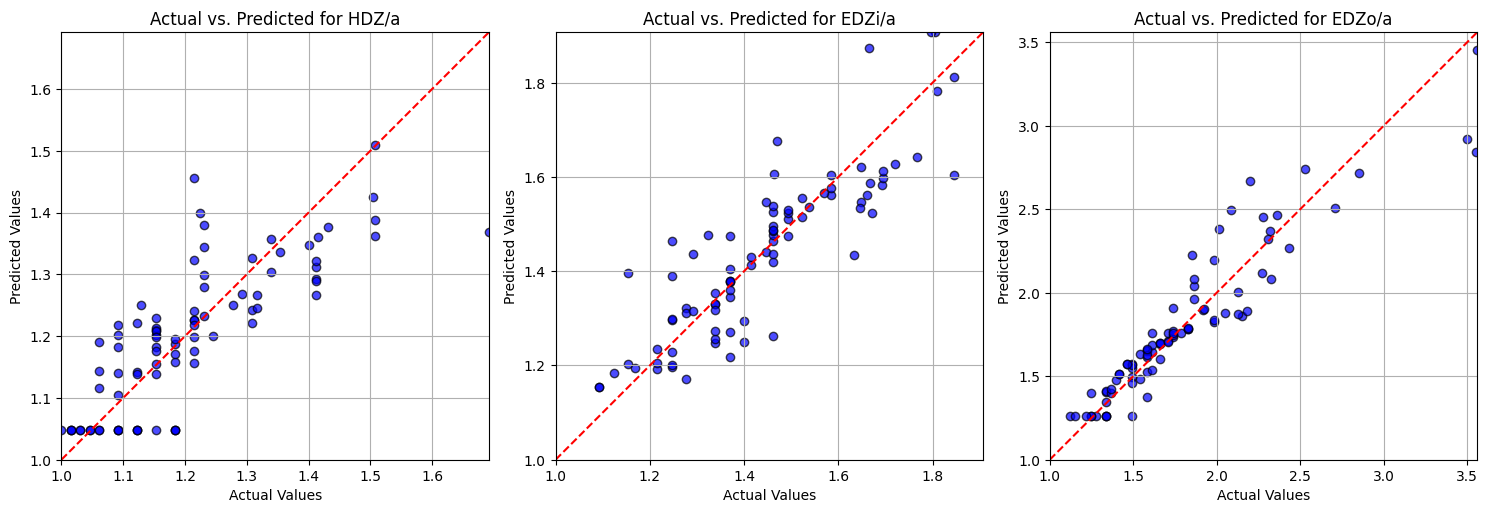

In [135]:

# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']

plt.figure(figsize=(15, 5))

for i, target in enumerate(targets):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_EDZ[target], predictions_optimum1[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'Actual vs. Predicted for {target}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_optimum1[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

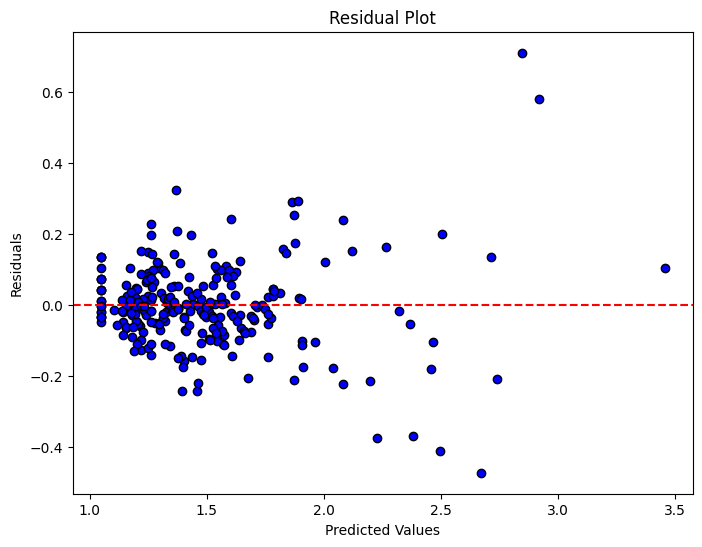

In [136]:
residuals = y_test_EDZ - predictions_optimum1
plt.figure(figsize=(8, 6))
plt.scatter(predictions_optimum1, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## **2. E, CI, UCS, Sig1, and Sig3**

In [137]:
EDZ_optimum2 = EDZ.drop(['T','mb peak', 's peak', 'SigZ', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_optimum2.columns:
        vif = variance_inflation_factor(EDZ_optimum2.values, EDZ_optimum2.columns.get_loc(column))
        print(f"VIF for {column}: {vif}")

VIF for E_15000: 1.5174615748722091
VIF for E_40000: 13.40151546270339
VIF for E_75000: 49.10852501218421
VIF for UCS: 30.72676201413135
VIF for CI: 23.56396191658241
VIF for Sig1: 10.175525166008416
VIF for Sig3: 10.058418268473725


In [138]:
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'UCS', 'CI']
stress_components = ['Sig1', 'Sig3']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_optimum2, rock_material_properties)
vif_stress_components = calculate_vif(EDZ_optimum2, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.459622
1  E_40000  11.793914
2  E_75000  42.842463
3      UCS  28.466557
4       CI  21.528379

VIF for Stress Components:
  Variable       VIF
0     Sig1  17.41933
1     Sig3  17.41933


In [139]:
#Dropping few columns accordingly
x_train_EDZ_optimum2 = x_train_EDZ.drop(['mb peak', 'T', 's peak', 'SigZ'], axis=1, inplace=False)
x_test_EDZ_optimum2 = x_test_EDZ.drop(['mb peak', 'T', 's peak', 'SigZ'], axis=1, inplace=False)

In [140]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to your training data
# gridsearch_MLPReg.fit(x_train_EDZ_optimum2, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_optimum2 = best_model.predict(x_test_EDZ_optimum2)

# # Evaluate the performance using an appropriate metric
# test_score_optimum2 = r2_score(y_test_EDZ, predictions_optimum2)
# print("R^2 Score on Test Data:", test_score_optimum2)

'''
Best Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (6, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.8019913116061052
'''

"\nBest Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (6, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.8019913116061052\n"

In [141]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(5, 6),
    activation='relu',
    alpha=0.0001,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to your training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_optimum2, y_train_EDZ)

# Make predictions on the test data
predictions_optimum2 = best_mlp_multioutput_regressor.predict(x_test_EDZ_optimum2)

# Evaluate the performance using the R^2 score
test_score_optimum2 = r2_score(y_test_EDZ, predictions_optimum2)
print("R^2 Score on Test Data:", test_score_optimum2)

# Calculate and print the mean absolute error
test_score_mae_optimum2 = mean_absolute_error(y_test_EDZ, predictions_optimum2)
print("\nMean Absolute Error on Test Data:", test_score_mae_optimum2)

R^2 Score on Test Data: 0.2706370456362816

Mean Absolute Error on Test Data: 0.1208393455752582


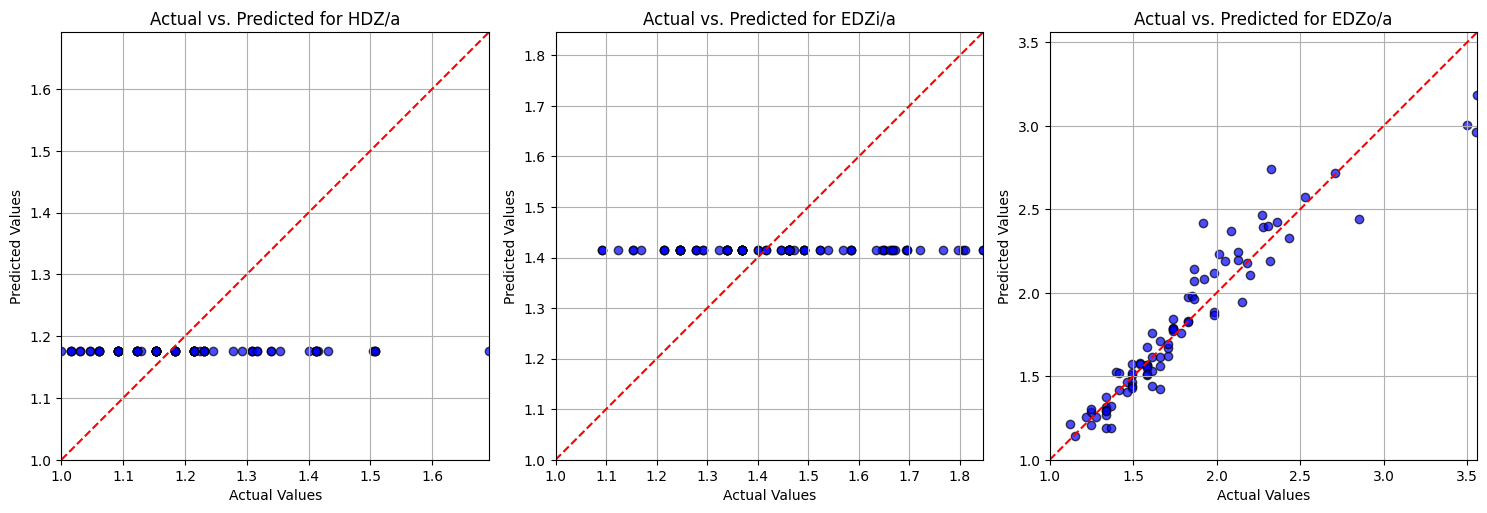

In [142]:
# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']

plt.figure(figsize=(15, 5))

for i, target in enumerate(targets):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_EDZ[target], predictions_optimum2[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'Actual vs. Predicted for {target}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_optimum2[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

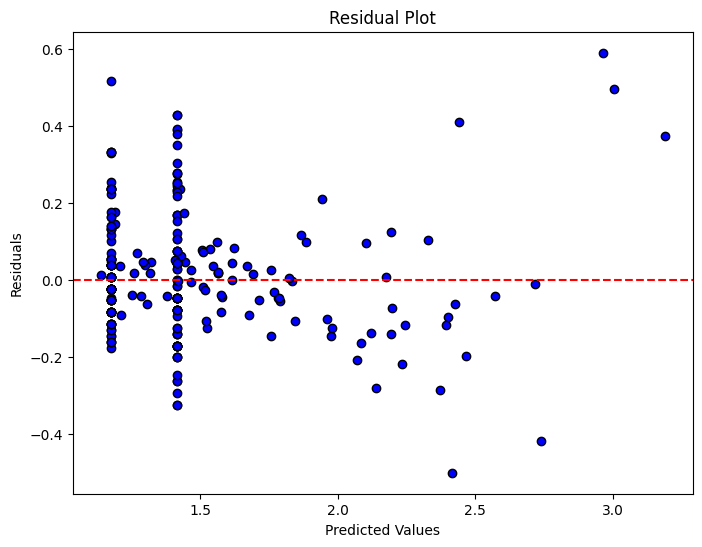

In [143]:
residuals = y_test_EDZ - predictions_optimum2
plt.figure(figsize=(8, 6))
plt.scatter(predictions_optimum2, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## **3. E, CI, UCS, T, Sig1, and Sig3**

In [144]:
EDZ_optimum3 = EDZ.drop(['mb peak', 's peak', 'SigZ', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_optimum3.columns:
        vif = variance_inflation_factor(EDZ_optimum3.values, EDZ_optimum3.columns.get_loc(column))
        print(f"VIF for {column}: {vif}")

VIF for E_15000: 1.5339006009719167
VIF for E_40000: 13.750061231892795
VIF for E_75000: 53.9824613891528
VIF for UCS: 33.36963436818391
VIF for CI: 32.27129515215482
VIF for T: 33.36209278997535
VIF for Sig1: 10.185464871087515
VIF for Sig3: 10.392434926897618


In [145]:
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'UCS', 'CI', 'T']
stress_components = ['Sig1', 'Sig3']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_optimum3, rock_material_properties)
vif_stress_components = calculate_vif(EDZ_optimum3, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.462387
1  E_40000  11.838381
2  E_75000  45.248849
3      UCS  32.234554
4       CI  27.168076
5        T  30.256351

VIF for Stress Components:
  Variable       VIF
0     Sig1  17.41933
1     Sig3  17.41933


In [146]:
#Dropping few columns accordingly
x_train_EDZ_optimum3 = x_train_EDZ.drop(['mb peak', 's peak', 'SigZ'], axis=1, inplace=False)
x_test_EDZ_optimum3 = x_test_EDZ.drop(['mb peak', 's peak', 'SigZ'], axis=1, inplace=False)

In [147]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to your training data
# gridsearch_MLPReg.fit(x_train_EDZ_optimum3, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_optimum3 = best_model.predict(x_test_EDZ_optimum3)

# # Evaluate the performance using an appropriate metric
# test_score_optimum3 = r2_score(y_test_EDZ, predictions_optimum3)
# print("R^2 Score on Test Data:", test_score_optimum3)

'''
Best Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (5, 3), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.8376960589177921
'''

"\nBest Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (5, 3), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.8376960589177921\n"

In [148]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(5, 6),
    activation='relu',
    alpha=0.0001,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to your training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_optimum3, y_train_EDZ)

# Make predictions on the test data
predictions_optimum3 = best_mlp_multioutput_regressor.predict(x_test_EDZ_optimum3)

# Evaluate the performance using the R^2 score
test_score_optimum3 = r2_score(y_test_EDZ, predictions_optimum3)
print("R^2 Score on Test Data:", test_score_optimum3)

# Calculate and print the mean absolute error
test_score_mae_optimum3 = mean_absolute_error(y_test_EDZ, predictions_optimum3)
print("\nMean Absolute Error on Test Data:", test_score_mae_optimum3)

R^2 Score on Test Data: 0.2815061981538347

Mean Absolute Error on Test Data: 0.11675797076875168


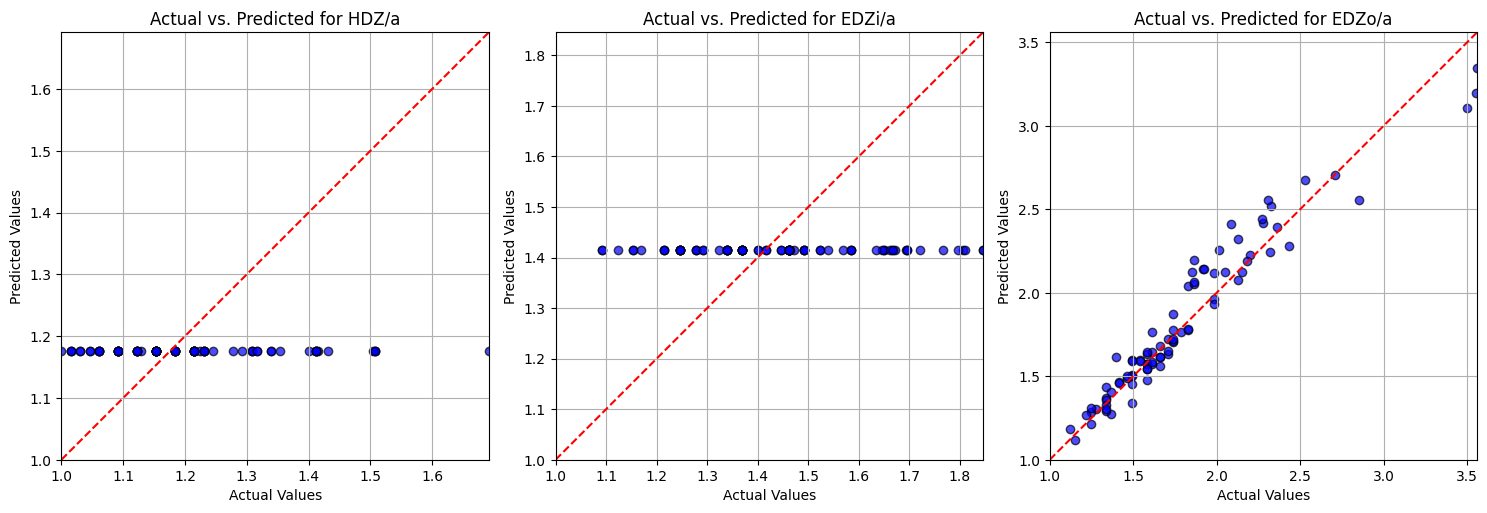

In [149]:
# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']

plt.figure(figsize=(15, 5))

for i, target in enumerate(targets):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_EDZ[target], predictions_optimum3[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'Actual vs. Predicted for {target}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_optimum3[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

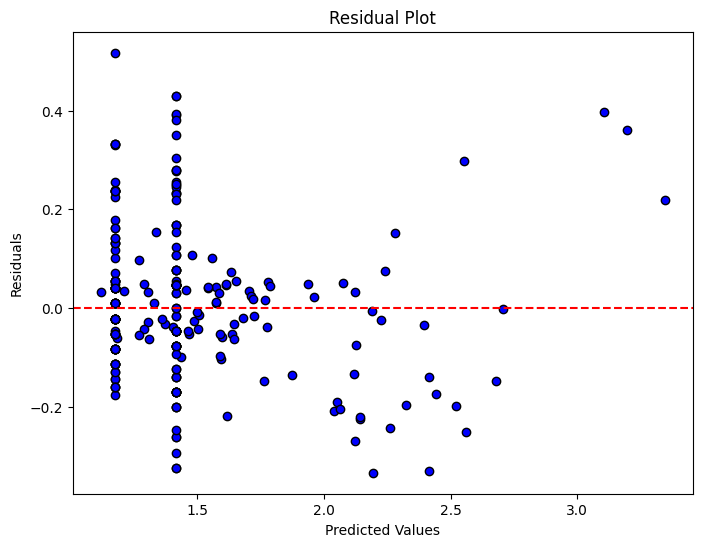

In [150]:
residuals = y_test_EDZ - predictions_optimum3
plt.figure(figsize=(8, 6))
plt.scatter(predictions_optimum3, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## **4. E, CI, UCS, T, Sig1, Sig3 and SigZ**



In [151]:
# But this is exactly similar as Regression Model without Hoek Brown Parameters. So refer to that group of cells

## **5. E, CI, SigZ, and Sig3**

In [152]:
EDZ_optimum5 = EDZ.drop(['UCS', 'mb peak', 's peak', 'Sig1', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_optimum5.columns:
        vif = variance_inflation_factor(EDZ_optimum5.values, EDZ_optimum5.columns.get_loc(column))
        print(f"VIF for {column}: {vif}")

VIF for E_15000: 1.278226778843078
VIF for E_40000: 7.202864975011722
VIF for E_75000: 40.14659814947009
VIF for CI: 26.849824169045068
VIF for T: 30.879562125605563
VIF for Sig3: 14.186004866655338
VIF for SigZ: 14.72292596050051


In [153]:
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'CI']
stress_components = ['SigZ', 'Sig3']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_optimum5, rock_material_properties)
vif_stress_components = calculate_vif(EDZ_optimum5, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.174591
1  E_40000   5.067764
2  E_75000  26.877773
3       CI  11.470021

VIF for Stress Components:
  Variable        VIF
0     SigZ  24.008915
1     Sig3  24.008915


In [154]:
#Dropping few columns accordingly
x_train_EDZ_optimum5 = x_train_EDZ.drop(['UCS', 'mb peak', 'T', 's peak', 'Sig1'], axis=1, inplace=False)
x_test_EDZ_optimum5 = x_test_EDZ.drop(['UCS', 'mb peak', 'T', 's peak', 'Sig1'], axis=1, inplace=False)

In [155]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to your training data
# gridsearch_MLPReg.fit(x_train_EDZ_optimum5, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_optimum5 = best_model.predict(x_test_EDZ_optimum5)

# # Evaluate the performance using an appropriate metric
# test_score_optimum5 = r2_score(y_test_EDZ, predictions_optimum5)
# print("R^2 Score on Test Data:", test_score_optimum5)

'''
Best Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.001, 'estimator__hidden_layer_sizes': (6, 4), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.7817298812500306
'''

"\nBest Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.001, 'estimator__hidden_layer_sizes': (6, 4), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.7817298812500306\n"

In [156]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(6, 4),
    activation='relu',
    alpha=0.001,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to your training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_optimum5, y_train_EDZ)

# Make predictions on the test data
predictions_optimum5 = best_mlp_multioutput_regressor.predict(x_test_EDZ_optimum5)

# Evaluate the performance using the R^2 score
test_score_optimum5 = r2_score(y_test_EDZ, predictions_optimum5)
print("R^2 Score on Test Data:", test_score_optimum5)

# Calculate and print the mean absolute error
test_score_mae_optimum5 = mean_absolute_error(y_test_EDZ, predictions_optimum5)
print("\nMean Absolute Error on Test Data:", test_score_mae_optimum5)

R^2 Score on Test Data: 0.7695225200108528

Mean Absolute Error on Test Data: 0.08603580667738668


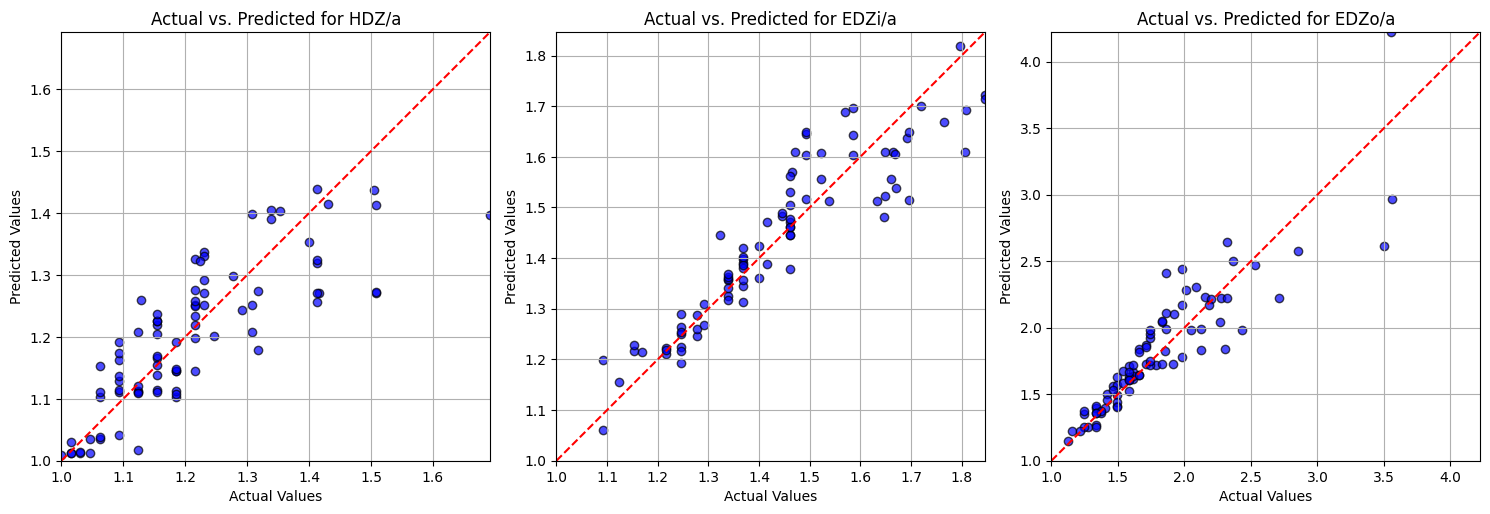

In [157]:

# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']

plt.figure(figsize=(15, 5))

for i, target in enumerate(targets):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_EDZ[target], predictions_optimum5[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'Actual vs. Predicted for {target}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_optimum5[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

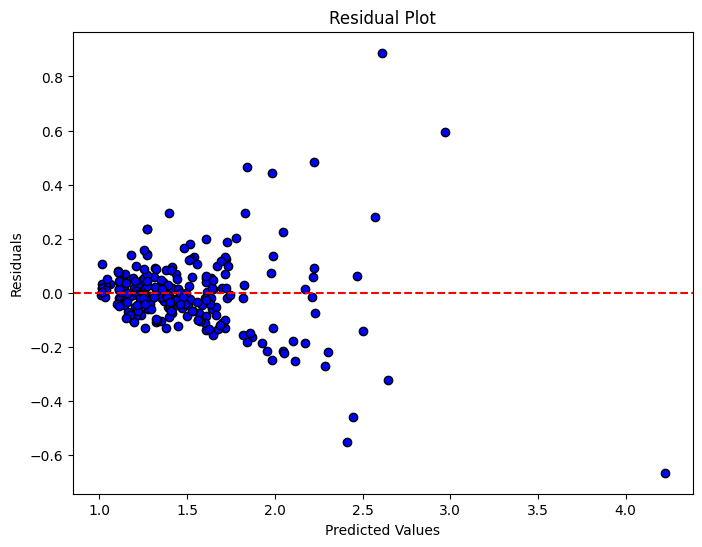

In [158]:
residuals = y_test_EDZ - predictions_optimum5
plt.figure(figsize=(8, 6))
plt.scatter(predictions_optimum5, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## **6. E, CI, UCS, SigZ, and Sig3**

In [159]:
EDZ_optimum6 = EDZ.drop(['T','mb peak', 's peak', 'Sig1', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_optimum6.columns:
        vif = variance_inflation_factor(EDZ_optimum6.values, EDZ_optimum6.columns.get_loc(column))
        print(f"VIF for {column}: {vif}")

VIF for E_15000: 1.528413230817445
VIF for E_40000: 13.228886549991733
VIF for E_75000: 47.78775826675226
VIF for UCS: 30.36584512808154
VIF for CI: 24.04703507957979
VIF for Sig3: 13.787016756360895
VIF for SigZ: 14.67401938603392


In [160]:
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'UCS', 'CI']
stress_components = ['SigZ', 'Sig3']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_optimum6, rock_material_properties)
vif_stress_components = calculate_vif(EDZ_optimum6, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.459622
1  E_40000  11.793914
2  E_75000  42.842463
3      UCS  28.466557
4       CI  21.528379

VIF for Stress Components:
  Variable        VIF
0     SigZ  24.008915
1     Sig3  24.008915


In [161]:
#Dropping few columns accordingly
x_train_EDZ_optimum6 = x_train_EDZ.drop(['mb peak', 'T', 's peak', 'Sig1'], axis=1, inplace=False)
x_test_EDZ_optimum6 = x_test_EDZ.drop(['mb peak', 'T', 's peak', 'Sig1'], axis=1, inplace=False)

In [162]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to your training data
# gridsearch_MLPReg.fit(x_train_EDZ_optimum6, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_optimum6 = best_model.predict(x_test_EDZ_optimum6)

# # Evaluate the performance using an appropriate metric
# test_score_optimum6 = r2_score(y_test_EDZ, predictions_optimum6)
# print("R^2 Score on Test Data:", test_score_optimum6)

'''
Best Parameters: {'estimator__activation': 'logistic', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (5, 2), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.7552545728754029
'''

"\nBest Parameters: {'estimator__activation': 'logistic', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (5, 2), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.7552545728754029\n"

In [163]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(5, 2),
    activation='logistic',
    alpha=0.0001,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to your training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_optimum6, y_train_EDZ)

# Make predictions on the test data
predictions_optimum6 = best_mlp_multioutput_regressor.predict(x_test_EDZ_optimum6)

# Evaluate the performance using the R^2 score
test_score_optimum6 = r2_score(y_test_EDZ, predictions_optimum6)
print("R^2 Score on Test Data:", test_score_optimum6)

# Calculate and print the mean absolute error
test_score_mae_optimum6 = mean_absolute_error(y_test_EDZ, predictions_optimum6)
print("\nMean Absolute Error on Test Data:", test_score_mae_optimum6)

R^2 Score on Test Data: 0.7657747678724797

Mean Absolute Error on Test Data: 0.08427353444749978


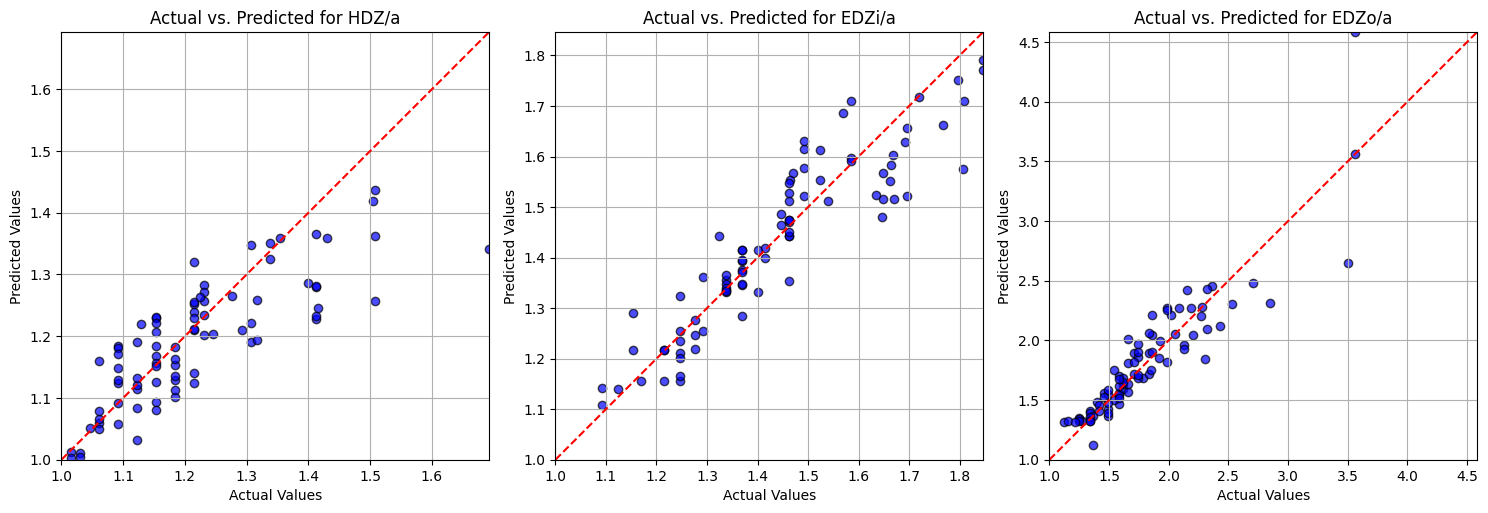

In [164]:
# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']

plt.figure(figsize=(15, 5))

for i, target in enumerate(targets):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_EDZ[target], predictions_optimum6[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'Actual vs. Predicted for {target}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_optimum6[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

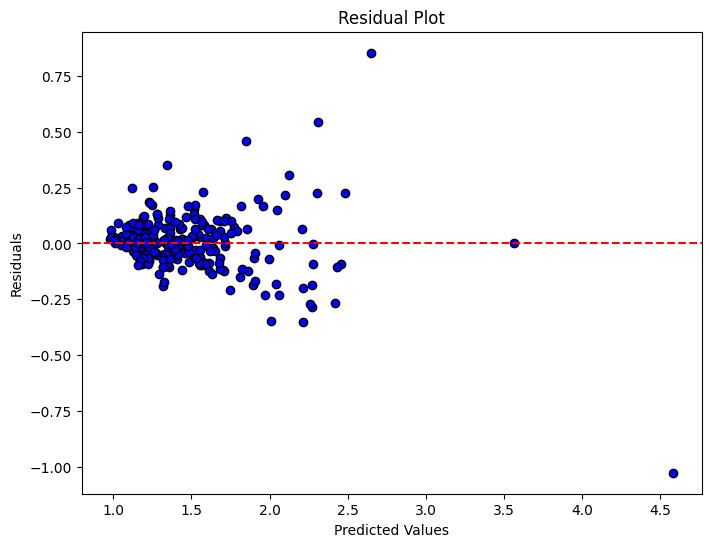

In [165]:
residuals = y_test_EDZ - predictions_optimum6
plt.figure(figsize=(8, 6))
plt.scatter(predictions_optimum6, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## **7. E, CI, UCS, T, SigZ, and Sig3**

In [166]:
EDZ_optimum7 = EDZ.drop(['mb peak', 's peak', 'Sig1', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_optimum7.columns:
        vif = variance_inflation_factor(EDZ_optimum7.values, EDZ_optimum7.columns.get_loc(column))
        print(f"VIF for {column}: {vif}")

VIF for E_15000: 1.547315083088686
VIF for E_40000: 13.594967947985
VIF for E_75000: 52.603510472768164
VIF for UCS: 32.903360042946915
VIF for CI: 33.01817302647589
VIF for T: 33.46000568407494
VIF for Sig3: 14.281776316604253
VIF for SigZ: 14.731461514207416


In [167]:
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'UCS', 'CI', 'T']
stress_components = ['SigZ', 'Sig3']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_optimum7, rock_material_properties)
vif_stress_components = calculate_vif(EDZ_optimum7, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.462387
1  E_40000  11.838381
2  E_75000  45.248849
3      UCS  32.234554
4       CI  27.168076
5        T  30.256351

VIF for Stress Components:
  Variable        VIF
0     SigZ  24.008915
1     Sig3  24.008915


In [168]:
#Dropping few columns accordingly
x_train_EDZ_optimum7 = x_train_EDZ.drop(['mb peak', 's peak', 'Sig1'], axis=1, inplace=False)
x_test_EDZ_optimum7 = x_test_EDZ.drop(['mb peak', 's peak', 'Sig1'], axis=1, inplace=False)

In [169]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to your training data
# gridsearch_MLPReg.fit(x_train_EDZ_optimum7, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_optimum7 = best_model.predict(x_test_EDZ_optimum7)

# # Evaluate the performance using an appropriate metric
# test_score_optimum7 = r2_score(y_test_EDZ, predictions_optimum7)
# print("R^2 Score on Test Data:", test_score_optimum7)

'''

Best Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (6, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.782324264081812
'''

"\n\nBest Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (6, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.782324264081812\n"

In [170]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(6, 6),
    activation='relu',
    alpha=0.001,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to your training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_optimum7, y_train_EDZ)

# Make predictions on the test data
predictions_optimum7 = best_mlp_multioutput_regressor.predict(x_test_EDZ_optimum7)

# Evaluate the performance using the R^2 score
test_score_optimum7 = r2_score(y_test_EDZ, predictions_optimum7)
print("R^2 Score on Test Data:", test_score_optimum7)

# Calculate and print the mean absolute error
test_score_mae_optimum7 = mean_absolute_error(y_test_EDZ, predictions_optimum7)
print("\nMean Absolute Error on Test Data:", test_score_mae_optimum7)

R^2 Score on Test Data: 0.7790985607349423

Mean Absolute Error on Test Data: 0.08055710017505902


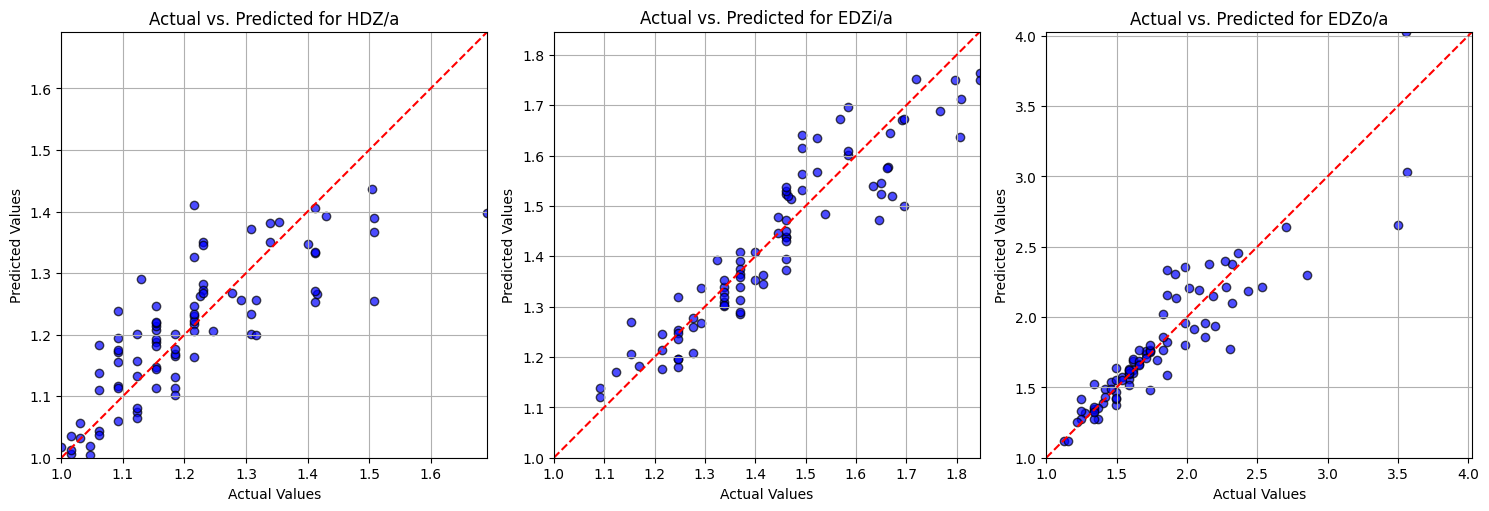

In [171]:
# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']

plt.figure(figsize=(15, 5))

for i, target in enumerate(targets):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_EDZ[target], predictions_optimum7[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'Actual vs. Predicted for {target}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_optimum7[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

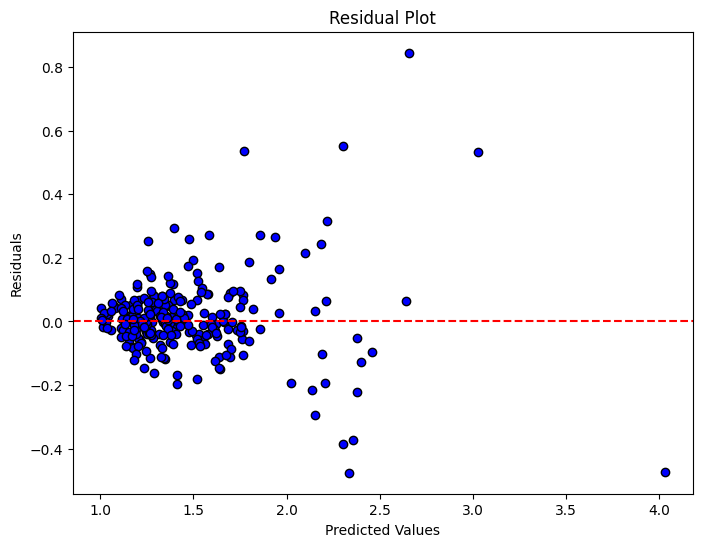

In [172]:
residuals = y_test_EDZ - predictions_optimum7
plt.figure(figsize=(8, 6))
plt.scatter(predictions_optimum7, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## **Plotting $R^2$ & $MAE$  for different Optimum MLPS**

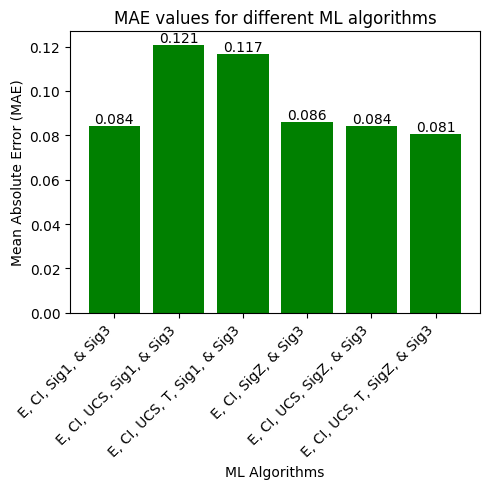

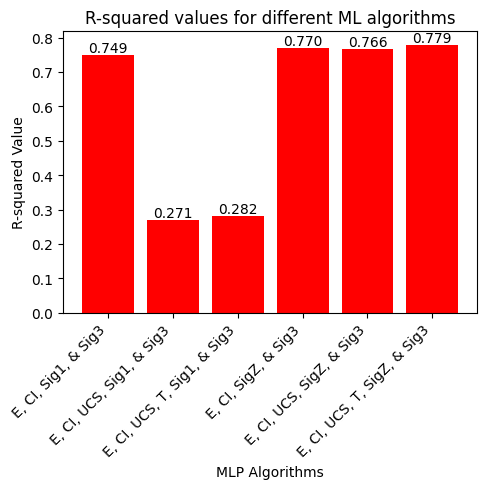

In [175]:
# Your MAE and R-squared values
mae_values = (test_score_mae_optimum1, test_score_mae_optimum2,
              test_score_mae_optimum3, test_score_mae_optimum5,
              test_score_mae_optimum6, test_score_mae_optimum7)

r_squared_values = (test_score_optimum1, test_score_optimum2,
                    test_score_optimum3, test_score_optimum5,
                    test_score_optimum6, test_score_optimum7)

# X-axis values
x_eval = np.array([1, 2, 3, 4, 5 , 6])
my_xticks = ['E, CI, Sig1, & Sig3', 'E, CI, UCS, Sig1, & Sig3',
             'E, CI, UCS, T, Sig1, & Sig3', 'E, CI, SigZ, & Sig3',
             'E, CI, UCS, SigZ, & Sig3','E, CI, UCS, T, SigZ, & Sig3']

# Plotting MAE values
plt.figure(figsize=(5, 5))
bars = plt.bar(x_eval, mae_values, color='green')
plt.xticks(x_eval, my_xticks, rotation=45, ha='right')
plt.xlabel('ML Algorithms')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE values for different ML algorithms')

# Displaying numeric values on top of the bars
for bar, value in zip(bars, mae_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.3f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Plotting R-squared values
plt.figure(figsize=(5, 5))
bars = plt.bar(x_eval, r_squared_values, color='red')
plt.xticks(x_eval, my_xticks, rotation=45, ha='right')
plt.xlabel('MLP Algorithms')
plt.ylabel('R-squared Value')
plt.title('R-squared values for different ML algorithms')

# Displaying numeric values on top of the bars
for bar, value in zip(bars, r_squared_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.3f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()